# Pre-Entrega4: Modelos de Aprendizaje No Supervisados

### üß≠ OBJETIVO GENERAL

Este proyecto tiene como objetivo aplicar algoritmos de **aprendizaje no supervisado**, espec√≠ficamente **clustering**, para descubrir patrones ocultos en nuestros datasets de producci√≥n de gas natural en Argentina.  

Trabajaremos con:

- **Dataset1**: Producci√≥n hist√≥rica agregada por cuenca y tipo de recurso.  
- **Dataset2**: Producci√≥n de pozos no convencionales.

Utilizaremos los siguientes algoritmos:

- **K-Means**  
- **DBSCAN**  
- **Gaussian Mixture Models (GMM)** (solo para Dataset2)

## Importaci√≥n de Librer√≠as  

Importamos las librer√≠as necesarias para la carga de datos, preprocesamiento, modelado y visualizaci√≥n.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

import warnings

# Ignorar advertencias para una salida m√°s limpia
warnings.filterwarnings('ignore')

# Configuraci√≥n de estilo para gr√°ficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Clustering con Dataset 1: Producci√≥n Hist√≥rica Agregada

El objetivo de esta secci√≥n es identificar grupos temporales con patrones de producci√≥n de gas natural similares, revelando as√≠ periodos con caracter√≠sticas distintivas o comportamientos an√≥malos en la serie hist√≥rica agregada.

###üîç Carga e Inspecci√≥n del Dataset1
Cargamos el dataset, revisamos columnas, tipos de datos y valores nulos. Filtramos los √∫ltimos 10 a√±os para capturar las tendencias m√°s recientes, y se renombraron algunas columnas.

In [ ]:
df1 = pd.read_csv('/content/serie-histrica-de-produccin-de-gas-natural-por-cuenca-y-sub-tipo-de-recurso-captulo-iv-.csv')

In [ ]:
df1.head()

indice_tiempo  produccion_gas_natural_cuenca_austral  \
0       2006-01                            856179.0548   
1       2006-02                            779265.9292   
2       2006-03                            807060.6516   
3       2006-04                            855962.9924   
4       2006-05                            905943.5735   

   produccion_gas_natural_cuenca_gsj  produccion_gas_natural_cuenca_neuquina  \
0                        357316.6790                            2.401347e+06   
1                        309565.3828                            2.288115e+06   
2                        384218.4085                            2.507932e+06   
3                        376149.2286                            2.395269e+06   
4                        409186.6946                            2.571095e+06   

   produccion_gas_natural_cuenca_noroeste  \
0                             609196.2466   
1                             532122.4430   
2                             588406.1140   
3                             570671.5738   
4                             562752.1099   

   produccion_gas_natural_cuenca_cuyana  produccion_gas_natural_total  \
0                             5201.6404                  4.229240e+06   
1                             4273.6100                  3.913342e+06   
2                             5135.2570                  4.292752e+06   
3                             4986.4970                  4.203039e+06   
4                             5265.7730                  4.454243e+06   

   produccion_gas_natural_total_diario  produccion_shale_gas  \
0                             136.4271                16.384   
1                             139.7622                13.954   
2                             138.4759                18.104   
3                             140.1013                19.627   
4                             143.6853                19.016   

   produccion_tight_gas  participacion_no_convencional  
0           32491.62664                         0.7686  
1           30778.94772                         0.7869  
2           33024.46882                         0.7697  
3           31342.49019                         0.7462  
4           39199.71537                         0.8805

In [ ]:
df1.shape

(231, 11)

In [ ]:
df1.dtypes

indice_tiempo                              object
produccion_gas_natural_cuenca_austral     float64
produccion_gas_natural_cuenca_gsj         float64
produccion_gas_natural_cuenca_neuquina    float64
produccion_gas_natural_cuenca_noroeste    float64
produccion_gas_natural_cuenca_cuyana      float64
produccion_gas_natural_total              float64
produccion_gas_natural_total_diario       float64
produccion_shale_gas                      float64
produccion_tight_gas                      float64
participacion_no_convencional             float64
dtype: object

**Filtrar los √∫ltimos 10 a√±os**

In [ ]:
# Convertir la columana 'indice_tiempo' en formato datetime
df1['indice_tiempo'] = pd.to_datetime(df1['indice_tiempo'])

# Cambiar de nombre a la columna 'indice_tiempo' por 'fecha'
df1.rename(columns={'indice_tiempo': 'fecha'}, inplace=True)

In [ ]:
# Agregar un columna solo con los meses que se llame 'mes' en formato numero entero
df1['mes'] = df1['fecha'].dt.month

In [ ]:
# Agregar un columna solo con los a√±os que se llame 'anio'
df1['anio'] = df1['fecha'].dt.year

In [ ]:
# Asegurarse de que la columna de fecha est√© en formato datetime

import pandas as pd
df1['fecha'] = pd.to_datetime(df1['fecha'])
df1.dtypes

fecha                                     datetime64[ns]
produccion_gas_natural_cuenca_austral            float64
produccion_gas_natural_cuenca_gsj                float64
produccion_gas_natural_cuenca_neuquina           float64
produccion_gas_natural_cuenca_noroeste           float64
produccion_gas_natural_cuenca_cuyana             float64
produccion_gas_natural_total                     float64
produccion_gas_natural_total_diario              float64
produccion_shale_gas                             float64
produccion_tight_gas                             float64
participacion_no_convencional                    float64
mes                                                int32
anio                                               int32
dtype: object

In [ ]:
# Ordenar por fecha para calcular los rezagos correctamente
df1 = df1.sort_values('fecha')

# Filtrar por rango de a√±os (2006 a 2024)
df1 = df1[(df1['fecha'].dt.year >= 2006) &
                   (df1['fecha'].dt.year <= 2024)]

In [ ]:
# Filtrar √∫ltimos 10 a√±os
df1 = df1[df1['fecha'] >= '2014-01-01']

In [ ]:
#Rango de Fechas
print(f"Rango de fechas del Dataset1 filtrado: {df1['fecha'].min().strftime('%Y-%m')} a {df1['fecha'].max().strftime('%Y-%m')}")

Rango de fechas del Dataset1 filtrado: 2014-01 a 2024-12


**Renombrar columnas**

In [ ]:
# Renombrar columnas
df1.rename(columns={
    'Gas Neuquina (miles de m3)': 'produccion_gas_natural_cuenca_neuquina',
    'Gas Austral (miles de m3)': 'produccion_gas_natural_cuenca_austral',
    'Gas Golfo San Jorge (miles de m3)': 'produccion_gas_natural_cuenca_gsj',
    'Gas Noroeste (miles de m3)': 'produccion_gas_natural_cuenca_noroeste',
    'Gas Cuyana (miles de m3)': 'produccion_gas_natural_cuenca_cuyana',
    'Gas shale (miles de m3)': 'produccion_shale_gas',
    'Gas tight (miles de m3)': 'produccion_tight_gas',
}, inplace=True)

### üßÆ Selecci√≥n y Creaci√≥n de Variables

Se incluyen variables como:

- Producci√≥n por cuenca y tipo de gas  
- A√±o, mes (como variables c√≠clicas), trimestres y estaciones


In [ ]:
# Transformaci√≥n C√≠clica del Mes
df1['mes_sin'] = np.sin(2 * np.pi * df1['mes'] / 12)
df1['mes_cos'] = np.cos(2 * np.pi * df1['mes'] / 12)

In [ ]:
# Variables Estacionales
def get_season(month):
    if month in [12, 1, 2]:
        return 'Verano'
    elif month in [3, 4, 5]:
        return 'Oto√±o'
    elif month in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'

df1['estacion'] = df1['mes'].apply(get_season)

In [ ]:
# Variables Trimestrales
df1['trimestre'] = df1['fecha'].dt.quarter

In [ ]:
# Variables Retardadas (Lagged Features)
df1['produccion_total_lag_1'] = df1['produccion_gas_natural_total'].shift(1)
df1['produccion_total_lag_2'] = df1['produccion_gas_natural_total'].shift(2)
df1['produccion_total_lag_3'] = df1['produccion_gas_natural_total'].shift(3)

# Manejar los valores nulos introducidos por los rezagos (NaNs en las primeras filas).
initial_rows_with_nan_lags = df1['produccion_total_lag_3'].isnull().sum()
df1.dropna(subset=['produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3'], inplace=True)
print(f"Se eliminaron {initial_rows_with_nan_lags} filas al inicio debido a los valores nulos en los rezagos.")

Se eliminaron 3 filas al inicio debido a los valores nulos en los rezagos.


In [ ]:
# Seleccionar caracter√≠sticas para clustering
features_1 = [
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'anio',
    'mes_sin',
    'mes_cos',
    'trimestre',
    'estacion',
    'produccion_total_lag_1',
    'produccion_total_lag_2',
    'produccion_total_lag_3'
]

# Verificar si todas las columnas existen antes de continuar
missing_cols = [col for col in features_1 if col not in df1.columns]
if missing_cols:
    print(f"Advertencia: Las siguientes columnas no se encontraron en df1 y ser√°n omitidas o se necesitar√° un paso previo para crearlas: {missing_cols}")
    # Remover las columnas faltantes de la lista de features para evitar errores
    features_1 = [col for col in features_1 if col in df1.columns]

X1 = df1[features_1].copy()

print(f"Caracter√≠sticas seleccionadas para Dataset1: {X1.columns.tolist()}")

Caracter√≠sticas seleccionadas para Dataset1: ['produccion_gas_natural_cuenca_neuquina', 'produccion_gas_natural_cuenca_austral', 'produccion_gas_natural_cuenca_gsj', 'produccion_gas_natural_cuenca_noroeste', 'produccion_gas_natural_cuenca_cuyana', 'produccion_shale_gas', 'produccion_tight_gas', 'anio', 'mes_sin', 'mes_cos', 'trimestre', 'estacion', 'produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3']


### üßº Preprocesamiento de Datos  

Las etapas de preprocesamiento de los datos incluyen:

- Manejo de Valores Nulos
- Escalado de Variables Num√©ricas
- Codificaci√≥n de Variables Categ√≥ricas
- Detecci√≥n y Manejo de Outliers

#### 1. Manejo de Nulos  

Revisamos y tratamos posibles valores nulos que puedan afectar los modelos.


In [ ]:
df1.isna().sum()

fecha                                     0
produccion_gas_natural_cuenca_austral     0
produccion_gas_natural_cuenca_gsj         0
produccion_gas_natural_cuenca_neuquina    0
produccion_gas_natural_cuenca_noroeste    0
produccion_gas_natural_cuenca_cuyana      0
produccion_gas_natural_total              0
produccion_gas_natural_total_diario       0
produccion_shale_gas                      0
produccion_tight_gas                      0
participacion_no_convencional             0
mes                                       0
anio                                      0
mes_sin                                   0
mes_cos                                   0
estacion                                  0
trimestre                                 0
produccion_total_lag_1                    0
produccion_total_lag_2                    0
produccion_total_lag_3                    0
dtype: int64

Se observa que en el Dataset 1 no posee valores nuelos, por lo que proseguimos con la codificaci√≥n de variables.

#### 2. Escalado de Variables Num√©ricas (StandardScaler)  

Usamos **Z-score** para escalar variables de producci√≥n por cuenca, por tipo de gas y variables temporales como `trimestres` y `variables retardadas`, asegurando que ninguna variable domine por su magnitud.


In [ ]:
# Revisar qu√© tipo de dato es 'trimestre'
print(df1['trimestre'].dtype)

int32


In [ ]:
# Revisar qu√© tipo de dato son las variables retardadas
print(df1['produccion_total_lag_1'].dtype)
print(df1['produccion_total_lag_2'].dtype)
print(df1['produccion_total_lag_3'].dtype)

float64
float64
float64


#### 3. Codificaci√≥n de Variables Categ√≥ricas (OneHotEncoder)  

Convertimos variables como `estaci√≥n` a formato num√©rico utilizando OneHotEncoder.


In [ ]:
# Revisar qu√© tipo de dato es 'estacion'
print(df1['estacion'].dtype)

object


In [ ]:
# Identificar columnas num√©ricas y categ√≥ricas
numerical_features_1 = [col for col in X1.columns if X1[col].dtype in ['int32', 'int64', 'float64'] and col not in [ 'mes']]
categorical_features_1 = [col for col in X1.columns if X1[col].dtype in ['object']]

print("\nColumnas Num√©ricas identificadas:", numerical_features_1)
print("Columnas Categ√≥ricas identificadas:", categorical_features_1)


Columnas Num√©ricas identificadas: ['produccion_gas_natural_cuenca_neuquina', 'produccion_gas_natural_cuenca_austral', 'produccion_gas_natural_cuenca_gsj', 'produccion_gas_natural_cuenca_noroeste', 'produccion_gas_natural_cuenca_cuyana', 'produccion_shale_gas', 'produccion_tight_gas', 'anio', 'mes_sin', 'mes_cos', 'trimestre', 'produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3']
Columnas Categ√≥ricas identificadas: ['estacion']


In [ ]:
# Preprocesamiento con Pipeline
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_1),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_1)
    ],
    remainder='passthrough'
)

# Aplicar el preprocesamiento
df1_processed_array = preprocessor_1.fit_transform(X1)

# Obtener los nombres de las caracter√≠sticas despu√©s del preprocesamiento
numerical_cols_processed = numerical_features_1
categorical_cols_processed = preprocessor_1.named_transformers_['cat'].get_feature_names_out(categorical_features_1)

# Combinar los nombres de las columnas procesadas
processed_feature_names_1 = list(numerical_cols_processed) + list(categorical_cols_processed)

# Convierte el array procesado de nuevo en un DataFrame
df1_processed = pd.DataFrame(df1_processed_array, columns=processed_feature_names_1, index=X1.index)


print(f"Dimensiones de los datos procesados para Dataset1: {df1_processed.shape}")
print(f"Columnas del DataFrame procesado: {df1_processed.columns.tolist()}")

Dimensiones de los datos procesados para Dataset1: (129, 18)
Columnas del DataFrame procesado: ['produccion_gas_natural_cuenca_neuquina', 'produccion_gas_natural_cuenca_austral', 'produccion_gas_natural_cuenca_gsj', 'produccion_gas_natural_cuenca_noroeste', 'produccion_gas_natural_cuenca_cuyana', 'produccion_shale_gas', 'produccion_tight_gas', 'anio', 'mes_sin', 'mes_cos', 'trimestre', 'produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3', 'estacion_Invierno', 'estacion_Oto√±o', 'estacion_Primavera', 'estacion_Verano']


#### 4. Detecci√≥n y Manejo de Outliers  

Identificamos y analizamos valores at√≠picos. Definimos un criterio para el manejo de estos outliers.


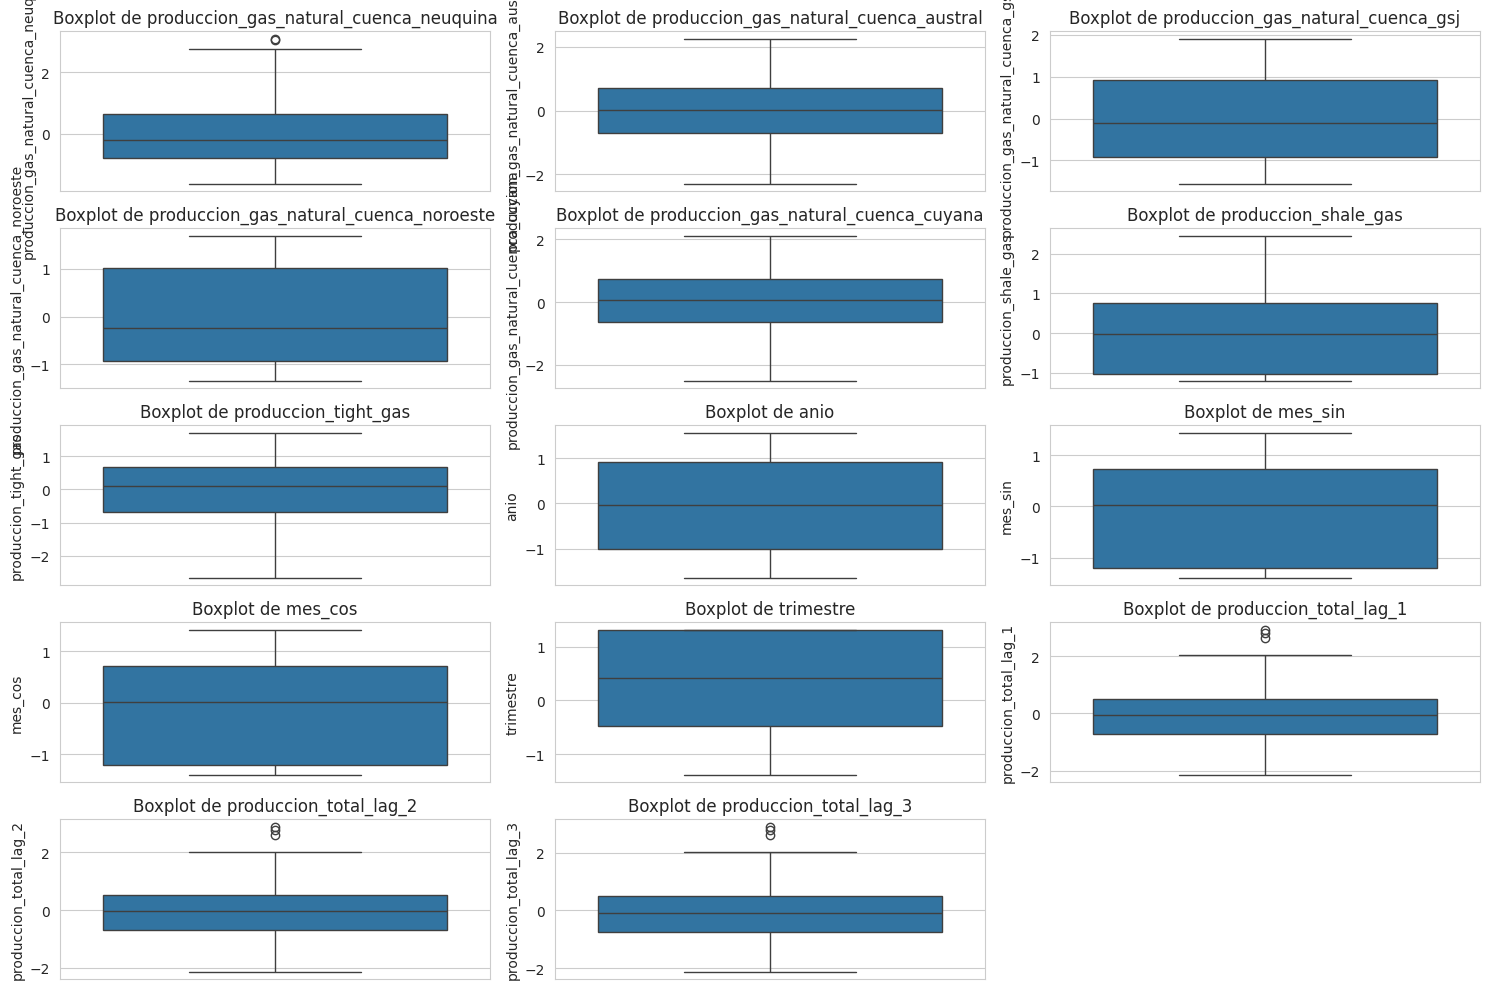

In [ ]:
# Seleccionar un subconjunto de columnas num√©ricas estandarizadas para visualizar outliers
cols_for_outlier_check = numerical_features_1

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_for_outlier_check):
    if col in df1_processed.columns:
        plt.subplot(len(cols_for_outlier_check)//3 + 1, 3, i + 1)
        sns.boxplot(y=df1_processed[col])
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()
    else:
        print(f"Advertencia: Columna '{col}' no encontrada en df1_processed.")

plt.show()

In [ ]:
# Identificar Outliers

# Funci√≥n para identificar outliers usando IQR
def identify_outliers_iqr(df, column, lower_quantile=0.25, upper_quantile=0.75, multiplier=1.5):
    Q1 = df[column].quantile(lower_quantile)
    Q3 = df[column].quantile(upper_quantile)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Lista para almacenar el total de outliers encontrados
total_outliers_count = 0
outlier_details = {}

# Iterar sobre las columnas num√©ricas para identificar outliers
for col in numerical_features_1:
    # Usar el DataFrame procesado para la detecci√≥n de outliers en datos escalados
    outliers_df = identify_outliers_iqr(df1_processed, col)
    num_outliers = len(outliers_df)
    total_outliers_count += num_outliers
    outlier_details[col] = num_outliers
    print(f"Columna '{col}': {num_outliers} outliers encontrados.")

# Calcular el total de puntos de datos
total_data_points = df1_processed.shape[0] * df1_processed.shape[1] # Total de elementos en el DataFrame procesado

# Calcular el porcentaje de outliers sobre el total de puntos de datos
percentage_outliers = (total_outliers_count / total_data_points) * 100 if total_data_points > 0 else 0

print(f"Total de outliers identificados en columnas num√©ricas: {total_outliers_count}")
print(f"Total de datos en el DataFrame 1 procesado: {total_data_points}")
print(f"Porcentaje de outliers sobre el total de datos: {percentage_outliers:.2f}%")


Columna 'produccion_gas_natural_cuenca_neuquina': 2 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_austral': 0 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_gsj': 0 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_noroeste': 0 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_cuyana': 0 outliers encontrados.
Columna 'produccion_shale_gas': 0 outliers encontrados.
Columna 'produccion_tight_gas': 0 outliers encontrados.
Columna 'anio': 0 outliers encontrados.
Columna 'mes_sin': 0 outliers encontrados.
Columna 'mes_cos': 0 outliers encontrados.
Columna 'trimestre': 0 outliers encontrados.
Columna 'produccion_total_lag_1': 3 outliers encontrados.
Columna 'produccion_total_lag_2': 3 outliers encontrados.
Columna 'produccion_total_lag_3': 3 outliers encontrados.
Total de outliers identificados en columnas num√©ricas: 11
Total de datos en el DataFrame 1 procesado: 2322
Porcentaje de outliers sobre el total de datos: 0.47%


**Outliers de 'produccion_gas_natural_cuenca_neuquina'**

In [ ]:
# Identificar outliers en 'produccion_gas_natural_cuenca_neuquina'

# Identificar los valores espec√≠ficos que son outliers en 'produccion_gas_natural_cuenca_neuquina'
outliers_neuquina_df = identify_outliers_iqr(df1_processed, 'produccion_gas_natural_cuenca_neuquina')

# Mostrar los valores de la columna 'produccion_gas_natural_cuenca_neuquina' que son outliers
print("\nValores de 'produccion_gas_natural_cuenca_neuquina' identificados como outliers:")
print(outliers_neuquina_df['produccion_gas_natural_cuenca_neuquina'])


Valores de 'produccion_gas_natural_cuenca_neuquina' identificados como outliers:
222    3.049106
223    3.094341
Name: produccion_gas_natural_cuenca_neuquina, dtype: float64


Los outliers de `produccion_gas_natural_cuenca_neuquina` para las filas 222 (3.055814) y 223 (3.101659) indican que la producci√≥n actual de esos meses (Julio 2024 y Agosto 2024, respectivamente) fue at√≠pica.

**Outliers de variables retardadas**

In [ ]:
#Identificar outliers en las variables retardadas:
#'produccion_total_lag_1', 'produccion_total_lag_2' y 'produccion_total_lag_3'

# Columnas de inter√©s para los outliers
lag_cols = ['produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3']

print("\n--- Outliers en variables retardadas ---")
for col in lag_cols:
    if col in df1_processed.columns:
        print(f"\nIdentificando outliers para la columna: '{col}'")
        # Identificar outliers usando la funci√≥n identify_outliers_iqr en el DataFrame procesado
        outliers = identify_outliers_iqr(df1_processed, col)

        if not outliers.empty:
            print(f"Outliers encontrados en '{col}':")
            original_outlier_rows = df1.loc[outliers.index]
            print(original_outlier_rows[['fecha', col.replace('_processed', '')]])
        else:
            print(f"No se encontraron outliers en la columna: '{col}'")
    else:
        print(f"Advertencia: La columna '{col}' no se encontr√≥ en df1_processed.")


--- Outliers en variables retardadas ---

Identificando outliers para la columna: 'produccion_total_lag_1'
Outliers encontrados en 'produccion_total_lag_1':
         fecha  produccion_total_lag_1
221 2024-06-01            4.654371e+06
223 2024-08-01            4.709074e+06
224 2024-09-01            4.744011e+06

Identificando outliers para la columna: 'produccion_total_lag_2'
Outliers encontrados en 'produccion_total_lag_2':
         fecha  produccion_total_lag_2
222 2024-07-01            4.654371e+06
224 2024-09-01            4.709074e+06
225 2024-10-01            4.744011e+06

Identificando outliers para la columna: 'produccion_total_lag_3'
Outliers encontrados en 'produccion_total_lag_3':
         fecha  produccion_total_lag_3
223 2024-08-01            4.654371e+06
225 2024-10-01            4.709074e+06
226 2024-11-01            4.744011e+06


Los outliers de las variables retardadas indican un patr√≥n:
- El valor 4.654371e+06 (que es un outlier) aparece en:

 - produccion_total_lag_1 para la fila 221

 - produccion_total_lag_2 para la fila 222

 - produccion_total_lag_3 para la fila 223

 Esto indica que la producci√≥n del mes que precede a la fila 221 (probablemente la producci√≥n de Mayo de 2024 o un mes similar si tus √≠ndices corresponden a una serie temporal) fue excepcionalmente alta y se manifest√≥ como un outlier en los lags de las filas subsiguientes.

- De manera similar, el valor 4.709074e+06 (otro outlier) en lag_1 (fila 223), lag_2 (fila 224), lag_3 (fila 225) significa que la producci√≥n del mes que precede a la fila 223 (probablemente Julio de 2024) tambi√©n fue un outlier.

- Y el valor 4.744011e+06 (otro outlier) en lag_1 (fila 224), lag_2 (fila 225), lag_3 (fila 226) significa que la producci√≥n del mes que precede a la fila 224 (probablemente Agosto de 2024) fue otro outlier.

**DECISI√ìN:**
Los outliers en nuestro Dataset estan relacionados a vlores productivos atipicos. Y c√≥mo nuestro objetivo es descubrir patrones y estructuras ocultas para identificaretapas productivas nos interesan los patrones que describen la mayor√≠a de los pozos o los per√≠odos de producci√≥n. Los outliers, por definici√≥n, representan desviaciones de esos patrones comunes. Por este motivo decidimos eliminarlos.

**Eliminar Outliers**

In [ ]:
# Elimina Outliers

# Almacenar el n√∫mero inicial de filas
initial_rows = df1_processed.shape[0]
print(f"Filas iniciales antes de remover outliers: {initial_rows}")

# Crear una copia para no modificar el DataFrame original mientras se itera
df1_processed_cleaned = df1_processed.copy()

# Identificar y remover filas que contienen outliers en cualquiera de las columnas num√©ricas
no_outliers_mask = pd.Series(True, index=df1_processed.index)

for col in numerical_features_1:
    if col in df1_processed_cleaned.columns:
        Q1 = df1_processed_cleaned[col].quantile(0.25)
        Q3 = df1_processed_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        col_mask = (df1_processed_cleaned[col] >= lower_bound) & (df1_processed_cleaned[col] <= upper_bound)
        no_outliers_mask = no_outliers_mask & col_mask
    else:
        print(f"Advertencia: Columna '{col}' no encontrada en df1_processed_cleaned. No se considerar√° para la eliminaci√≥n de outliers.")

# Aplicar la m√°scara para filtrar las filas sin outliers
df1_processed_cleaned = df1_processed_cleaned[no_outliers_mask]

# Almacenar el n√∫mero de filas despu√©s de remover outliers
rows_after_removing_outliers = df1_processed_cleaned.shape[0]
print(f"Filas despu√©s de remover outliers: {rows_after_removing_outliers}")

# Calcular el total de filas eliminadas
removed_rows_count = initial_rows - rows_after_removing_outliers
print(f"Total de filas eliminadas: {removed_rows_count}")

# Imprimir las dimensiones del DataFrame despu√©s de remover outliers
print(f"Dimensiones del DataFrame despu√©s de remover outliers: {df1_processed_cleaned.shape}")

# Guardar los cambios en df1_processed
df1_processed = df1_processed_cleaned

# Guardar los cambios en df1
df1 = df1_processed

Filas iniciales antes de remover outliers: 129
Filas despu√©s de remover outliers: 123
Total de filas eliminadas: 6
Dimensiones del DataFrame despu√©s de remover outliers: (123, 18)


### ü§ñ Aplicaci√≥n de Algoritmos de Clustering

Implementaremos K-Means y DBSCAN para el Dataset 1.


#### üìä K-Means  

Aplicamos K-Means y determinamos el n√∫mero √≥ptimo de clusters con:

- **M√©todo del Codo**  
- **Coeficiente de Silueta**

Ambos m√©todos permiten evaluar la cohesi√≥n y separaci√≥n de los grupos.


In [ ]:
# Definir lista de columnas a usar para K-Means
features_for_clustering = [
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'anio',
    'mes_sin',
    'mes_cos',
    'trimestre',
    'produccion_total_lag_1',
    'produccion_total_lag_2',
    'produccion_total_lag_3',
    'estacion_Invierno',
    'estacion_Oto√±o',
    'estacion_Primavera',
    'estacion_Verano'
]

# Crear un sub-DataFrame con las caracter√≠sticas deseadas para el clustering
df_for_models = df1_processed[features_for_clustering].copy()

K = 2, Coeficiente de Silueta = 0.262
K = 3, Coeficiente de Silueta = 0.218
K = 4, Coeficiente de Silueta = 0.211
K = 5, Coeficiente de Silueta = 0.213
K = 6, Coeficiente de Silueta = 0.204
K = 7, Coeficiente de Silueta = 0.205
K = 8, Coeficiente de Silueta = 0.202
K = 9, Coeficiente de Silueta = 0.204
K = 10, Coeficiente de Silueta = 0.202


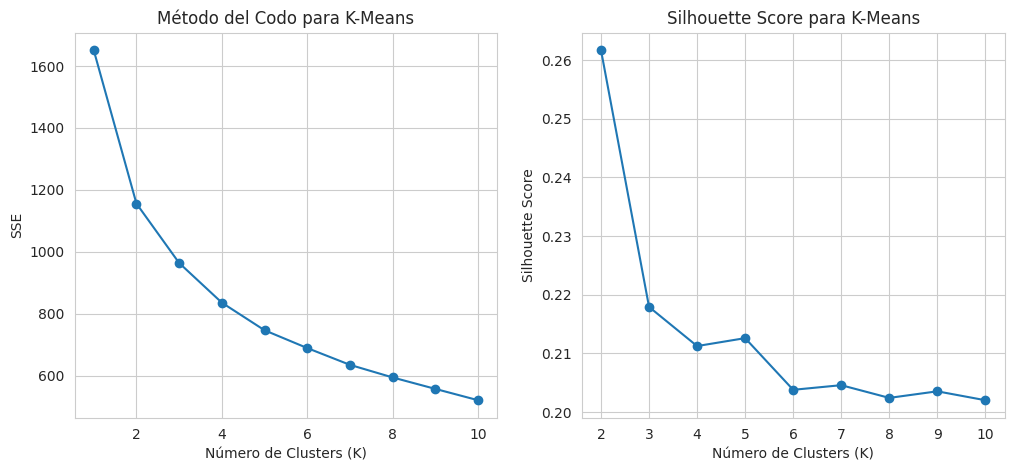

In [ ]:
# Determinar el n√∫mero √≥ptimo de clusters (k) para K-Means

# M√©todo del Codo
sse = []
k_range = range(1, 11)

# Usar df_for_models para clustering
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_for_models)
    sse.append(kmeans.inertia_)

# Visualizar el m√©todo del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.title('M√©todo del Codo para K-Means')
plt.xlabel('N√∫mero de Clusters (K)')
plt.ylabel('SSE')

# Coeficiente de Silueta
silhouette_scores = []

# Usar df_for_models para clustering
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_for_models)
    score = silhouette_score(df_for_models, cluster_labels)
    silhouette_scores.append(score)
    print(f"K = {k}, Coeficiente de Silueta = {score:.3f}")

# Visualizar Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score para K-Means')
plt.xlabel('N√∫mero de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

1. **M√©todo del Codo (Elbow Method)**

La curva de inercia comienza a estabilizarse en K=3 o K=4, lo que sugiere que uno de estos valores podr√≠a ser adecuado. Sin embargo, la reducci√≥n de la inercia despu√©s de este punto es menos pronunciada, haciendo que la elecci√≥n no sea completamente clara.

2. **Coeficiente de Silueta (Silhouette Score)**

El valor m√°s alto del coeficiente se obtiene en K=2 (0.282), lo que indica que en esta configuraci√≥n los grupos est√°n m√°s claramente separados y los puntos dentro de cada grupo son m√°s similares entre s√≠. A partir de K=3, la puntuaci√≥n disminuye significativamente, alcanzando su punto m√°s bajo en K=6 (0.282).

**Conclusi√≥n Preliminar:**

Aunque el M√©todo del Codo sugiere K=3 o K=4, su interpretaci√≥n es ambigua. En cambio, el Coeficiente de Silueta ofrece un respaldo claro y objetivo a K=2 como la mejor opci√≥n. Esto indica que los datos se estructuran de forma m√°s natural y eficiente en dos clusters bien diferenciados.

In [ ]:
# Seleccionar k √≥ptimo
k_optimo_kmeans1 = 2

kmeans1 = KMeans(n_clusters=k_optimo_kmeans1, random_state=42, n_init=10)
# Ajustar los datos procesados
kmeans1.fit(df_for_models)
# Predecir clusters para los datos procesados
cluster_labels_kmeans1 = kmeans1.predict(df_for_models)
# Asignar las etiquetas de cluster a df_for_models
df1.loc[df_for_models.index, 'kmeans_cluster'] = cluster_labels_kmeans1


print(f"\nSe ha ejecutado K-Means con k = {k_optimo_kmeans1} para Dataset1.")
print(f"Conteo de elementos por cluster K-Means:\n{df1['kmeans_cluster'].value_counts()}")


Se ha ejecutado K-Means con k = 2 para Dataset1.
Conteo de elementos por cluster K-Means:
kmeans_cluster
1.0    73
0.0    50
Name: count, dtype: int64


#### üåê DBSCAN  

Exploramos este algoritmo basado en densidad. Las claves:

- **eps**: Radio de vecindad  
- **min_samples**: M√≠nimo de puntos por vecindad  

Utilizamos el **gr√°fico de la distancia al K-vecino m√°s cercano** para elegir un buen valor de `eps`.


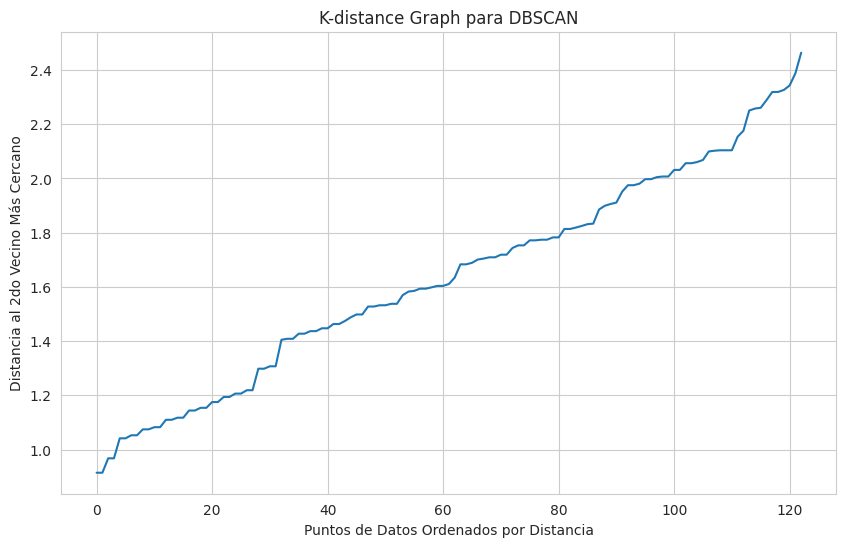

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_for_models)
distances, indices = nbrs.kneighbors(df_for_models)
distances = np.sort(distances[:, 1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph para DBSCAN')
plt.xlabel('Puntos de Datos Ordenados por Distancia')
plt.ylabel('Distancia al 2do Vecino M√°s Cercano')
plt.show()

Basado en el Gr√°fico de Distancia K:

- `eps` (√©psilon): Aproximadamente entre 1.6 y 1.7. Por lo que elegimos un valor como 1.65 para empezar.

- `min_samples` (puntos m√≠nimos): 3 dado que el gr√°fico es para el 2do vecino m√°s cercano.

In [ ]:
# # Aplicaci√≥n y evaluaci√≥n de DBSCAN
## con eps = 1.65 y min_samples = 3
dbscan = DBSCAN(eps=1.65, min_samples=3)
clusters_dbscan = dbscan.fit_predict(df_for_models)

# # Unir los clusters al DataFrame original o procesado
df1.loc[df_for_models.index, 'dbscan_cluster'] = clusters_dbscan

# # Evaluar la puntuaci√≥n de silueta (ignorar -1, que es ruido)
unique_labels = np.unique(clusters_dbscan)
n_clusters_excluding_noise = len(unique_labels[unique_labels != -1])

if n_clusters_excluding_noise > 1:
    # Calcular la puntuaci√≥n de la silueta excluyendo los puntos de ruido (-1)
    score_dbscan = silhouette_score(df_for_models[clusters_dbscan != -1], clusters_dbscan[clusters_dbscan != -1])
    print(f"Silhouette Score para DBSCAN (excluyendo ruido): {score_dbscan}")
elif len(unique_labels) > 1:
    # Si hay clusters pero s√≥lo un cluster sin ruido, todav√≠a no se puede calcular la silueta sin ruido
     print("DBSCAN encontr√≥ clusters, pero s√≥lo un cluster sin ruido para calcular la puntuaci√≥n de silueta.")
else:
    print("DBSCAN no form√≥ suficientes clusters (o s√≥lo encontr√≥ ruido) para calcular la puntuaci√≥n de silueta.")

print(f"\nSe ha ejecutado DBSCAN con eps = {dbscan.eps} y min_samples = {dbscan.min_samples} para Dataset1.")
print(f"Conteo de elementos por cluster DBSCAN (Dataset1):\n{df1['dbscan_cluster'].value_counts()}")
print("Nota: El cluster -1 representa outliers (ruido).")

Silhouette Score para DBSCAN (excluyendo ruido): 0.38254804739986914

Se ha ejecutado DBSCAN con eps = 1.65 y min_samples = 3 para Dataset1.
Conteo de elementos por cluster DBSCAN (Dataset1):
dbscan_cluster
-1.0    86
 3.0     6
 7.0     5
 0.0     4
 4.0     4
 1.0     4
 6.0     4
 5.0     4
 2.0     3
 8.0     3
Name: count, dtype: int64
Nota: El cluster -1 representa outliers (ruido).


Dado que hay algunos puntos que se clasificaron como ruido, el primer paso ser√≠a aumentar el valor de eps de forma incremental. Vuelvemos a ejecutar DBSCAN con pero con los siguientes valores `eps = 1.8` y` min_samples = 3`

In [ ]:
# --- Para DBSCAN ---
## con eps = 1.80 y min_samples = 3

# # Aplicaci√≥n y evaluaci√≥n de DBSCAN
dbscan_v2 = DBSCAN(eps=1.80, min_samples=3)
clusters_dbscan_v2 = dbscan_v2.fit_predict(df_for_models)

# Asignar a la columna 'dbscan_cluster'
df1.loc[df_for_models.index, 'dbscan_cluster'] = clusters_dbscan_v2

# Evaluar la puntuaci√≥n de silueta
unique_labels_v2 = np.unique(clusters_dbscan_v2)
n_clusters_excluding_noise_v2 = len(unique_labels_v2[unique_labels_v2 != -1])

if n_clusters_excluding_noise_v2 > 1:
    score_dbscan_v2 = silhouette_score(df_for_models[clusters_dbscan_v2 != -1], clusters_dbscan_v2[clusters_dbscan_v2 != -1])
    print(f"Silhouette Score para DBSCAN (excluyendo ruido) con eps={dbscan_v2.eps}: {score_dbscan_v2}")
elif len(unique_labels_v2) > 1:
    print("DBSCAN encontr√≥ clusters, pero s√≥lo un cluster sin ruido para calcular la puntuaci√≥n de silueta.")
else:
    print("DBSCAN no form√≥ suficientes clusters (o s√≥lo encontr√≥ ruido) para calcular la puntuaci√≥n de silueta.")

print(f"\nSe ha ejecutado DBSCAN con eps = {dbscan_v2.eps} y min_samples = {dbscan_v2.min_samples} para Dataset1.")
print(f"Conteo de elementos por cluster DBSCAN (Dataset1):\n{df1['dbscan_cluster'].value_counts()}")
print("Nota: El cluster -1 representa outliers (ruido).")

Silhouette Score para DBSCAN (excluyendo ruido) con eps=1.8: 0.36522969237272096

Se ha ejecutado DBSCAN con eps = 1.8 y min_samples = 3 para Dataset1.
Conteo de elementos por cluster DBSCAN (Dataset1):
dbscan_cluster
-1.0    74
 0.0    12
 2.0     6
 7.0     5
 5.0     4
 4.0     4
 3.0     4
 9.0     4
 6.0     4
 1.0     3
 8.0     3
Name: count, dtype: int64
Nota: El cluster -1 representa outliers (ruido).


Manteniendo `min_samples = 3`, al aumentar `eps a 1.8`, el Silhouette Score se mantiene en un nivel muy alto, mientras que el n√∫mero de puntos de ruido disminuye (74). Esto significa que estamos capturando la misma buena calidad de cl√∫steres que antes, y posiblemente con cl√∫steres un poco m√°s grandes.

### üìâ An√°lisis Exploratorio y Visualizaci√≥n de Clusters  

Reducimos la dimensionalidad con **PCA** para visualizar los resultados y analizamos promedios por cluster.


In [ ]:
# Reducci√≥n de Dimensionalidad con PCA
pca_1 = PCA(n_components=2)
# Aplicar PCA en df_for_models
X1_pca = pca_1.fit_transform(df_for_models)

# Asignar los componentes PCA a df1 usando el √≠ndice de df_for_models
df1.loc[df_for_models.index, 'pca1'] = X1_pca[:, 0]
df1.loc[df_for_models.index, 'pca2'] = X1_pca[:, 1]

#### üìå K-Means  

- An√°lisis de Clusters K-Means (Dataset1)


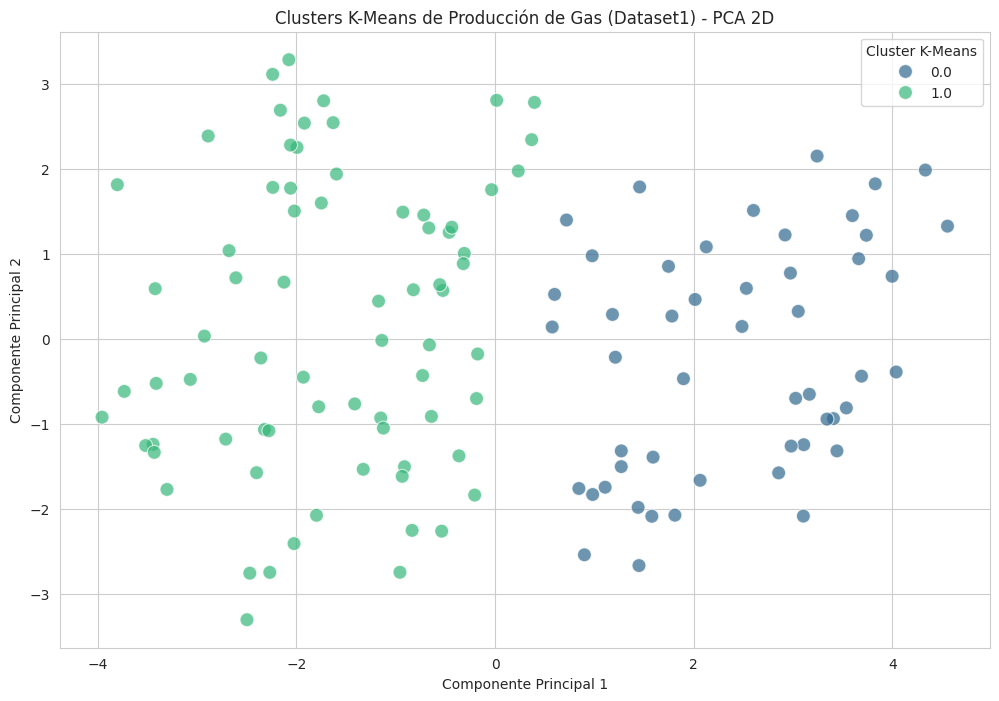


Caracter√≠sticas promedio por Cluster (K-Means - Dataset1):
                produccion_gas_natural_cuenca_neuquina  \
kmeans_cluster                                           
0.0                                          -0.853054   
1.0                                           0.410840   

                produccion_gas_natural_cuenca_austral  \
kmeans_cluster                                          
0.0                                         -0.097850   
1.0                                          0.174539   

                produccion_gas_natural_cuenca_gsj  \
kmeans_cluster                                      
0.0                                      1.105846   
1.0                                     -0.657159   

                produccion_gas_natural_cuenca_noroeste  \
kmeans_cluster                                           
0.0                                           1.120012   
1.0                                          -0.663200   

                produccion_gas_

In [ ]:
## K-MEANS
#2 Clusters

# Visualizaci√≥n de Clusters (K-Means)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='kmeans_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters K-Means de Producci√≥n de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.show()

# Caracter√≠sticas promedio por Cluster (K-Means)
non_temporal_features = [col for col in features_for_clustering if col not in ['anio', 'mes_sin', 'mes_cos', 'trimestre', 'estacion_Invierno', 'estacion_Oto√±o', 'estacion_Primavera', 'estacion_Verano']]

# Calcular el promedio de las caracter√≠sticas NO TEMPORALES para cada cl√∫ster
cluster_summary_kmeans1 = df1.loc[df_for_models.index].groupby('kmeans_cluster')[
    non_temporal_features
].mean()
print("\nCaracter√≠sticas promedio por Cluster (K-Means - Dataset1):")
print(cluster_summary_kmeans1)

# An√°lisis de Variables Temporales por Cluster (K-Means)
print("\nAn√°lisis Temporal por Cluster (K-Means - Dataset1):")

# Preparar un DataFrame para el an√°lisis temporal con los valores originales
df1_for_temporal_analysis = df1.loc[df_for_models.index].copy()


for cluster_id in sorted(df1_for_temporal_analysis['kmeans_cluster'].unique()):
    # Filtrar el DataFrame de an√°lisis temporal por el cluster_id actual
    cluster_data_temporal = df1_for_temporal_analysis[df1_for_temporal_analysis['kmeans_cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} ---")

    # Revisar que las columnas existan en el DataFrame y que sean las originales
    if 'anio' in cluster_data_temporal.columns:
        print(f"A√±os representados: {cluster_data_temporal['anio'].min()} - {cluster_data_temporal['anio'].max()}")
    else:
        print("Advertencia: La columna 'anio' original no encontrada para an√°lisis temporal.")

    # mes
    if 'mes' in cluster_data_temporal.columns:
        print(f"Meses (distribuci√≥n): \n{cluster_data_temporal['mes'].value_counts(normalize=True).sort_index().round(2)}")
    else:
        print("Advertencia: La columna 'mes' original no encontrada para an√°lisis temporal.")

    # estacion
    if 'estacion' in cluster_data_temporal.columns:
        print(f"Estaciones (distribuci√≥n): \n{cluster_data_temporal['estacion'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'estacion' original no encontrada para an√°lisis temporal.")

    # trimetre
    if 'trimestre' in cluster_data_temporal.columns:
        print(f"Trimestres (distribuci√≥n): \n{cluster_data_temporal['trimestre'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'trimestre' original no encontrada para an√°lisis temporal.")


#### **An√°lisis de Clusters K-Means (Dataset1)**

El modelo K-Means identific√≥ dos cl√∫steres bien diferenciados en la producci√≥n de gas no convencional en Argentina durante la √∫ltima d√©cada, revelando una transici√≥n clara entre dos etapas productivas.

---

###### **Cluster 0 (Color Azul/Gris en el gr√°fico):**

Representa los a√±os 2014-2018, una etapa temprana del desarrollo del gas no convencional, con niveles de producci√≥n m√°s moderados.

*  **Producci√≥n por Cuenca:**
Alta producci√≥n en Golfo San Jorge (1.10) y Noroeste (1.12). En cambio, la Cuenca Neuquina (-0.85), principal impulsora del shale gas, muestra valores muy por debajo del promedio.

* **Tipo de recurso:**
Shale gas (-1.03) y tight gas (-0.17) presentan bajos niveles de producci√≥n.

* **Producci√≥n total (lag):**
Indicadores de producci√≥n total hist√≥rica en niveles consistentemente bajos.

* **Patr√≥n temporal:**
Distribuci√≥n mensual uniforme sin estacionalidad clara.

**Interpretaci√≥n del Cluster 0:**

Este cl√∫ster agrupa per√≠odos caracterizados por una baja producci√≥n general de gas natural, en particular desde la Cuenca Neuquina y en los recursos no convencionales como el shale gas. En contraste, las cuencas tradicionales como Golfo San Jorge y Noroeste presentan una producci√≥n significativamente superior al promedio, y la Cuenca Cuyana tambi√©n muestra un leve protagonismo.
Adem√°s, los indicadores de producci√≥n total con rezago (lag) reflejan niveles consistentemente bajos, lo que refuerza la idea de una etapa previa al auge del desarrollo no convencional.
En conjunto, este cl√∫ster representa un modelo de producci√≥n m√°s conservador y basado en cuencas hist√≥ricas, previo al cambio estructural impulsado por el shale gas en a√±os posteriores.

---

###### **Cluster 1 (Color Verde en el Gr√°fico)**

Corresponde a la etapa de mayor desarrollo y alta producci√≥n en Argentina, impulsada principalmente por recursos no convencionales.

* **Producci√≥n por Cuenca:** Destaca la Cuenca Neuquina con niveles por encima del promedio (0.41), mientras que las cuencas tradicionales como Golfo San Jorge (-0.65) y Noroeste (-0.66) est√°n por debajo del promedio.

* **Producci√≥n por Tipo de Recurso:** El shale gas (0.54) y tight gas (0.20) presentan una contribuci√≥n significativa y superior al promedio.

* **Producci√≥n Total Retardada:** Los valores con rezagos (lag 1, 2 y 3) muestran una producci√≥n sostenida y por encima del promedio.

* **An√°lisis Temporal:** Abarca los a√±os 2018-2024, reflejando los a√±os m√°s recientes y de mayor crecimiento del sector, con una distribuci√≥n uniforme sin estacionalidad marcada. El volumen sostenido de producci√≥n es el principal factor diferenciador.

**Interpretaci√≥n del Cluster 1:**

Este patr√≥n refleja un patr√≥n de producci√≥n reciente dominado por la Cuenca Neuquina y los recursos no convencionales, con un desempe√±o superior al promedio. En contraste, las cuencas tradicionales presentan una menor producci√≥n. En conjunto, representa la etapa actual de expansi√≥n y consolidaci√≥n del gas no convencional en Argentina.

#### üìå DBSCAN  

- An√°lisis de Clusters DBSCAN (Dataset1)  
- DBSCAN ‚Äì An√°lisis del Ruido


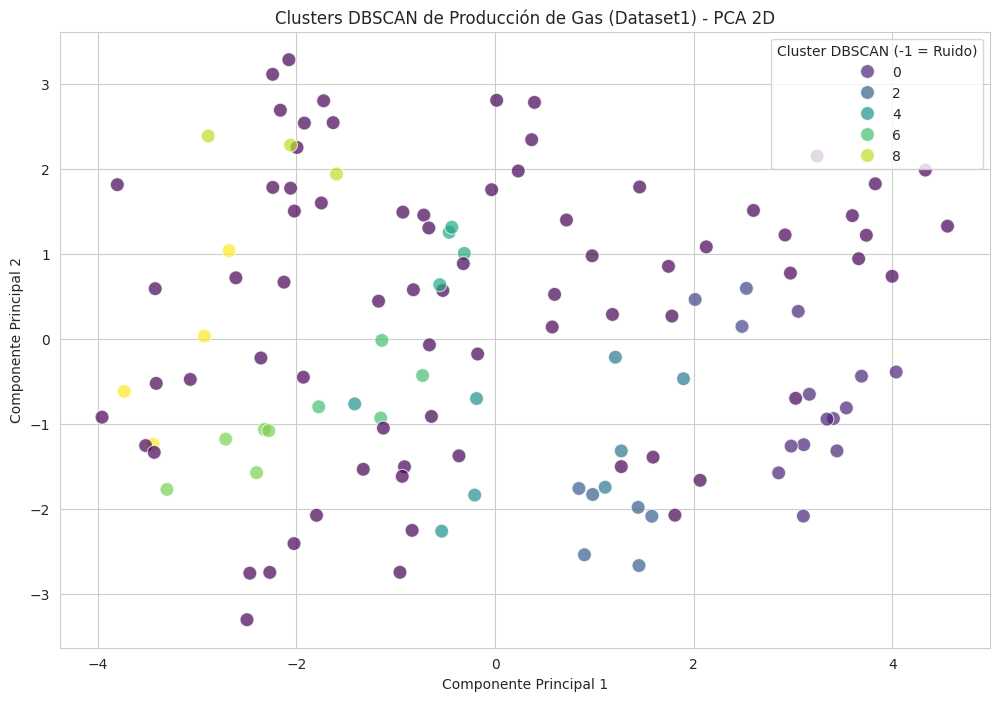


Caracter√≠sticas promedio por Cluster (DBSCAN - Dataset1):
                produccion_gas_natural_cuenca_neuquina  \
dbscan_cluster                                           
0.0                                          -1.086219   
1.0                                          -0.662440   
2.0                                          -0.713330   
3.0                                          -0.630909   
4.0                                           0.201823   
5.0                                          -0.210042   
6.0                                           0.386535   
7.0                                           0.527365   
8.0                                           0.781153   
9.0                                           1.673073   

                produccion_gas_natural_cuenca_austral  \
dbscan_cluster                                          
0.0                                         -0.489782   
1.0                                          0.242192   
2.0            

In [ ]:
## DBSCAN

# Visualizaci√≥n de Clusters (DBSCAN)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='dbscan_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters DBSCAN de Producci√≥n de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.show()

# Caracter√≠sticas promedio por Cluster (DBSCAN)
print("\nCaracter√≠sticas promedio por Cluster (DBSCAN - Dataset1):")

# Definir las caracter√≠sticas no temporales para el c√°lculo de promedios.
non_temporal_features = [
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'produccion_total_lag_1',
    'produccion_total_lag_2',
    'produccion_total_lag_3'
]

# Crear un DataFrame para el an√°lisis basado en df1 y df_for_models.index
df1_for_dbscan_analysis = df1.loc[df_for_models.index].copy()

# Filtrar el ruido (-1.0) antes de calcular los promedios.
clusters_no_noise_dbscan = df1_for_dbscan_analysis[df1_for_dbscan_analysis['dbscan_cluster'] != -1.0]

# Calcula el promedio de las caracter√≠sticas NO TEMPORALES para cada cl√∫ster.
cluster_summary_dbscan = clusters_no_noise_dbscan.groupby('dbscan_cluster')[
    non_temporal_features
].mean()
print(cluster_summary_dbscan)

# An√°lisis de Variables Temporales por Cluster (DBSCAN)
print("\nAn√°lisis Temporal por Cluster (DBSCAN - Dataset1):")

# Filtrar el ruido para el an√°lisis temporal tambi√©n.
clusters_no_noise_temporal_dbscan = df1_for_dbscan_analysis[df1_for_dbscan_analysis['dbscan_cluster'] != -1.0]

# Iterar sobre cada ID de cl√∫ster encontrado (excluyendo el ruido)
for cluster_id in sorted(clusters_no_noise_temporal_dbscan['dbscan_cluster'].unique()):
    # Filtra el DataFrame por el cluster_id actual
    cluster_data_temporal_dbscan = clusters_no_noise_temporal_dbscan[clusters_no_noise_temporal_dbscan['dbscan_cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} (DBSCAN) ---")

    # Comprobar y mostrar las estad√≠sticas de las columnas temporales originales
for cluster_id in sorted(clusters_no_noise_temporal_dbscan['dbscan_cluster'].unique()):
    cluster_data_temporal_dbscan = clusters_no_noise_temporal_dbscan[clusters_no_noise_temporal_dbscan['dbscan_cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} (DBSCAN) ---")
    if 'anio' in cluster_data_temporal_dbscan.columns:
        print(f"A√±os representados: {cluster_data_temporal_dbscan['anio'].min()} - {cluster_data_temporal_dbscan['anio'].max()}")
    else:
        print("Advertencia: La columna 'anio' original no encontrada en el DataFrame para an√°lisis temporal.")

    if 'mes' in cluster_data_temporal_dbscan.columns:
        print(f"Meses (distribuci√≥n): \n{cluster_data_temporal_dbscan['mes'].value_counts(normalize=True).sort_index().round(2)}")
    else:
        print("Advertencia: La columna 'mes' original no encontrada en el DataFrame para an√°lisis temporal. (Si usaste mes_sin/mes_cos, los promedios ya est√°n en cluster_summary_dbscan).")

    if 'estacion' in cluster_data_temporal_dbscan.columns:
        print(f"Estaciones (distribuci√≥n): \n{cluster_data_temporal_dbscan['estacion'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'estacion' original no encontrada en el DataFrame para an√°lisis temporal. (Si usaste OHEs, puedes promediar las columnas 'estacion_X' en su lugar).")

    if 'trimestre' in cluster_data_temporal_dbscan.columns:
        print(f"Trimestres (distribuci√≥n): \n{cluster_data_temporal_dbscan['trimestre'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'trimestre' original no encontrada en el DataFrame para an√°lisis temporal. (Si est√° estandarizada, ya se promedi√≥ en cluster_summary_dbscan).")


#### An√°lisis de Clusters DBSCAN (Dataset1)

El modelo DBSCAN identific√≥ 10 cl√∫steres que segmentan la evoluci√≥n de la producci√≥n de gas no convencional en Argentina en tres grandes etapas: tradicional, transici√≥n y auge.

**1. Era Tradicional (Cl√∫steres 0.0 y 1.0)**

* Predominan cuencas convencionales (GSJ, Noroeste, Cuyana).
* Producci√≥n muy baja en Neuquina y nula en recursos no convencionales (shale y tight gas).
* Producci√≥n total baja.
* Se concentran en los a√±os m√°s tempranos del dataset.

**Insight clave:** Reflejan un modelo productivo centrado en cuencas maduras, sin presencia no convencional.

**2. Etapa de Transici√≥n (Cl√∫steres 2.0 a 5.0)**
* Neuquina y Austral comienzan a crecer.
* Tight gas gana protagonismo, mientras las cuencas tradicionales pierden peso.
* Shale gas aparece t√≠midamente.
* Producci√≥n total empieza a repuntar.

**Temporalidad:** A√±os intermedios, con distribuci√≥n de trimestres m√°s diversa.

**Insight clave:** Esta fase marca el cambio hacia un modelo m√°s moderno, con se√±ales claras del cambio de matriz productiva.

**3. Auge de No Convencionales (Cl√∫steres 6.0 a 9.0)**

* Neuquina se vuelve dominante, especialmente en el cl√∫ster 9.0.
* Shale gas alcanza sus valores m√°ximos, impulsando el crecimiento total.
* Tight gas tiene un rol variable pero importante.
* Cuencas tradicionales quedan relegadas.

**Temporalidad:** A√±os recientes; algunos cl√∫steres est√°n concentrados en trimestres espec√≠ficos, reflejando momentos productivos puntuales.

**Insight clave:** Esta etapa representa el pleno auge del modelo no convencional, liderado por el shale gas neuquino.

**Conclusiones**

* DBSCAN permite segmentar la evoluci√≥n hist√≥rica del gas argentino con mayor sensibilidad a transiciones sutiles.
* Aporta un enfoque complementario a modelos como K-Means, captando tanto microestructuras como el cambio progresivo en el patr√≥n productivo.

####üìå DBSCAN

* An√°lisis de Clusters DBSCAN (Dataset1)
* DBSCAN ‚Äì An√°lisis del Ruido


In [ ]:
# Analisis de Ruido en DBSCAN

# Filtrar los puntos que DBSCAN identific√≥ como ruido (-1)
df_for_dbscan_analysis_noise = df1.loc[df_for_models.index].copy()
ruido_dbscan = df_for_dbscan_analysis_noise[df_for_dbscan_analysis_noise['dbscan_cluster'] == -1.0]

print(f"Se identificaron {len(ruido_dbscan)} puntos como ruido por DBSCAN.")

if not ruido_dbscan.empty:
    ruido_data_for_analysis = ruido_dbscan.copy()

    print("Filas correspondientes a los puntos de ruido (-1):")
    cols_to_show_ruido = non_temporal_features.copy()
    if 'dbscan_cluster' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('dbscan_cluster')
    if 'kmeans_cluster' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('kmeans_cluster')
    if 'pca1' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('pca1')
    if 'pca2' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('pca2')

    cols_to_show_ruido_existing = [col for col in cols_to_show_ruido if col in ruido_data_for_analysis.columns]

    print(ruido_data_for_analysis[cols_to_show_ruido_existing].round(6))

    print("\nCaracter√≠sticas promedio de los puntos de ruido:")
    production_features_existing_in_noise = [col for col in non_temporal_features if col in ruido_data_for_analysis.columns]
    if production_features_existing_in_noise:
        print(ruido_data_for_analysis[production_features_existing_in_noise].mean().round(6))
    else:
        print("No hay caracter√≠sticas de producci√≥n para promediar en los puntos de ruido (o las columnas no coinciden).")

    print("\nAn√°lisis Temporal de los puntos de ruido:")
    temporal_cols = ['anio', 'mes', 'trimestre', 'estacion']
    temporal_cols_existing = [col for col in temporal_cols if col in ruido_data_for_analysis.columns]

    for col in temporal_cols_existing:
        print(f"Distribuci√≥n de '{col}' en puntos de ruido:")
        if col in ['anio', 'mes', 'trimestre']:
            print(ruido_data_for_analysis[col].value_counts(normalize=True).sort_index().round(6))
        else:
            print(ruido_data_for_analysis[col].value_counts(normalize=True).round(6))

else:
    print("No se identificaron puntos como ruido por DBSCAN con los par√°metros actuales.")

Se identificaron 74 puntos como ruido por DBSCAN.
Filas correspondientes a los puntos de ruido (-1):
     produccion_gas_natural_cuenca_neuquina  \
99                                -1.620845   
100                               -1.257701   
101                               -1.407556   
108                               -1.077623   
109                               -1.585335   
..                                      ...   
216                                0.750528   
217                                0.871963   
218                                1.471779   
220                                2.763456   
227                                0.752393   

     produccion_gas_natural_cuenca_austral  produccion_gas_natural_cuenca_gsj  \
99                               -1.365153                           0.782760   
100                               0.091966                           0.905411   
101                              -0.240600                           0.683668   
108       

**Conclusi√≥n del An√°lisis de Ruido:**

Conclusi√≥n sobre el An√°lisis de Ruido
Los 86 puntos clasificados como ruido por DBSCAN representan observaciones at√≠picas que no encajan en los cl√∫steres densos identificados. Aunque sus valores promedios son cercanos al promedio general, tanto el an√°lisis individual como la visualizaci√≥n en PCA muestran que son casos aislados o dispersos.

Estos outliers est√°n distribuidos a lo largo de todo el per√≠odo analizado, con una leve concentraci√≥n en algunos trimestres, lo que indica que las anomal√≠as en la producci√≥n pueden ocurrir en cualquier momento, reflejando condiciones excepcionales que los m√©todos basados en densidad no logran agrupar.

#### üìä Comparaci√≥n  

- Comparaci√≥n entre K-Means y DBSCAN


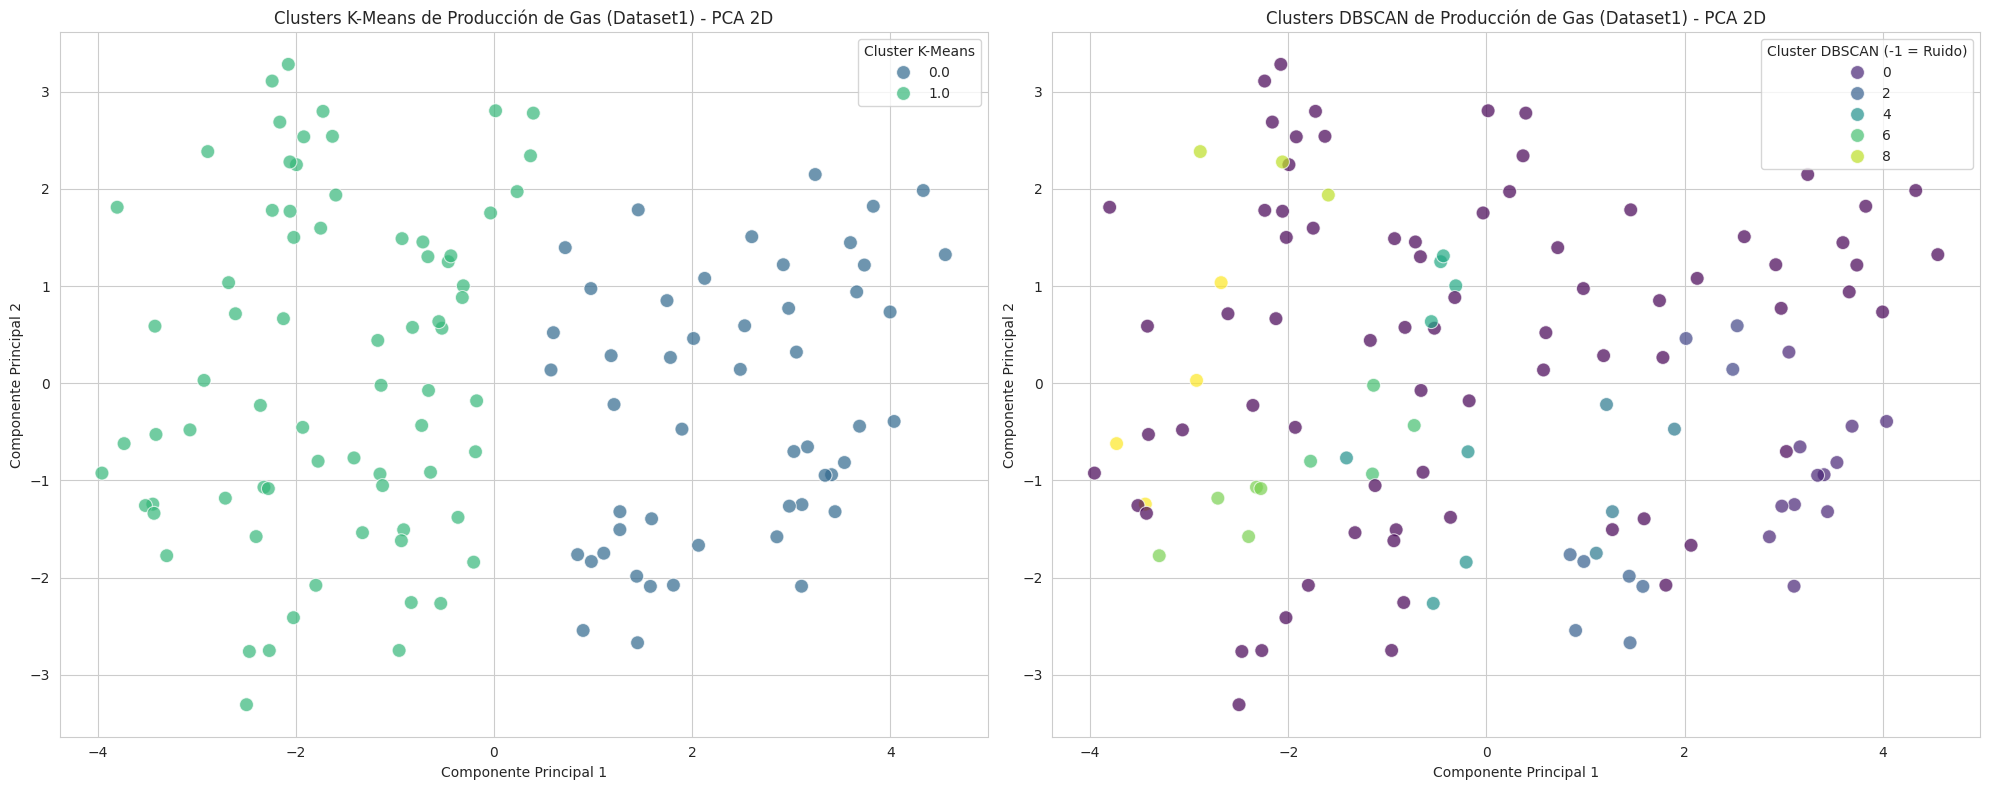

In [ ]:
# Visualizaci√≥n de Clusters con K-Means y DBSCAN

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# Gr√°fico de Clusters (K-Means)
plt.subplot(1, 2, 1)
sns.scatterplot(x='pca1', y='pca2', hue='kmeans_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters K-Means de Producci√≥n de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')

# Gr√°fico de Clusters (DBSCAN)
plt.subplot(1, 2, 2)
sns.scatterplot(x='pca1', y='pca2', hue='dbscan_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters DBSCAN de Producci√≥n de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')

plt.tight_layout()
plt.show()

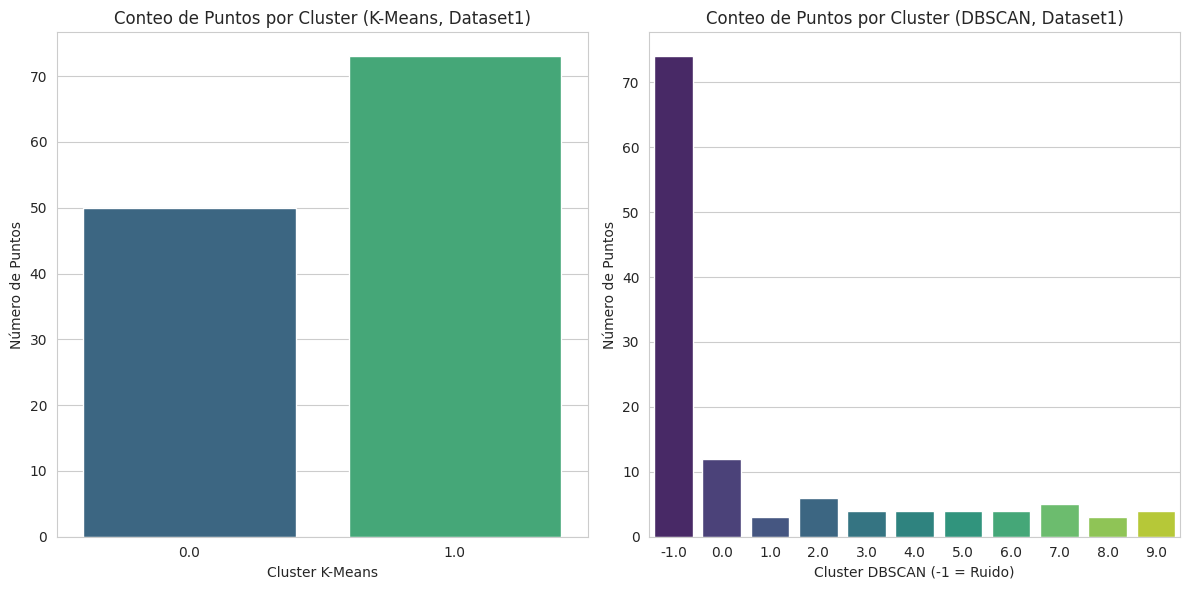

In [ ]:
# Conteo de Puntos por Clusters segun Modelo

import pandas as pd
import matplotlib.pyplot as plt

#Seleccionar solo los clusters
df1_clustered = df1.loc[df_for_models.index].copy()

# Comparaci√≥n de Conteo de Clusters
plt.figure(figsize=(12, 6))

# Conteo para K-Means
plt.subplot(1, 2, 1)
kmeans_counts = df1_clustered['kmeans_cluster'].value_counts().sort_index()
sns.barplot(x=kmeans_counts.index, y=kmeans_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (K-Means, Dataset1)')
plt.xlabel('Cluster K-Means')
plt.ylabel('N√∫mero de Puntos')

# Conteo para DBSCAN
plt.subplot(1, 2, 2)
dbscan_counts = df1_clustered['dbscan_cluster'].value_counts().sort_index()
sns.barplot(x=dbscan_counts.index, y=dbscan_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (DBSCAN, Dataset1)')
plt.xlabel('Cluster DBSCAN (-1 = Ruido)')
plt.ylabel('N√∫mero de Puntos')

plt.tight_layout()
plt.show()

### üßæ **Conclusiones Generales del Dataset1**

El an√°lisis conjunto de K-Means y DBSCAN permiti√≥ revelar patrones complementarios en la evoluci√≥n de la producci√≥n de gas en Argentina.

K-Means expuso una visi√≥n clara y estructurada, diferenciando dos grandes etapas:

* Una fase tradicional, asociada a los primeros a√±os del per√≠odo, dominada por cuencas convencionales.

* Una fase moderna, marcada por el auge de Neuquina y la expansi√≥n del shale y tight gas.

DBSCAN, en cambio, brind√≥ una perspectiva m√°s detallada, identificando m√∫ltiples cl√∫steres que capturan fases de transici√≥n m√°s sutiles, con matices temporales y productivos, y revelando microestructuras que reflejan la evoluci√≥n gradual del sector. Adem√°s, permiti√≥ detectar puntos de ruido que representan casos at√≠picos a lo largo del tiempo.

Ambos enfoques, el macrosc√≥pico de K-Means y el granular de DBSCAN, se complementan para ofrecer una lectura integral de las din√°micas hist√≥ricas y estructurales de la industria del gas natural.

---

## 2. Clustering con Dataset 2: Producci√≥n de Pozos No Convencionales  

El objetivo es segmentar pozos para **identificar grupos con caracter√≠sticas de producci√≥n o geogr√°ficas similares**, y detectar pozos at√≠picos (outliers).

Aplicaremos:

- **K-Means**  
- **DBSCAN**  
- **GMM (Gaussian Mixture Models)**


###üîç Carga e Inspecci√≥n del Dataset 2
Cargamos el dataset, revisamos columnas, tipos de datos y valores nulos. Filtramos los √∫ltimos 10 a√±os para capturar las tendencias m√°s recientes, y se renombraron algunas columnas.

In [ ]:
df2 = pd.read_csv('/content/produccin-de-pozos-de-gas-y-petrleo-no-convencional.csv')

In [ ]:
df2.head()

idempresa  anio  mes  idpozo  prod_pet  prod_gas  prod_agua  iny_agua  \
0      YSUR  2018    1  132488       0.0   171.937       0.00       0.0   
1      YSUR  2017    1  130021       0.0   245.850      16.68       0.0   
2      YSUR  2018    1  132487       0.0   514.696      17.00       0.0   
3      YSUR  2015    1  137212       0.0   422.110       0.00       0.0   
4      YSUR  2018    1  132361       0.0   217.103       7.30       0.0   

   iny_gas  iny_co2  ...    cuenca  provincia  coordenadax coordenaday  \
0      0.0      0.0  ...  NEUQUINA  Rio Negro   -67.864960  -39.016722   
1      0.0      0.0  ...  NEUQUINA    Neuqu√©n   -69.733102  -39.024859   
2      0.0      0.0  ...  NEUQUINA  Rio Negro   -67.837875  -39.019313   
3      0.0      0.0  ...  NEUQUINA    Neuqu√©n   -69.255971  -38.860779   
4      0.0      0.0  ...  NEUQUINA    Neuqu√©n   -69.231360  -38.869270   

   tipo_de_recurso      proyecto clasificacion subclasificacion  \
0  NO CONVENCIONAL      GAS PLUS   EXPLOTACION       DESARROLLO   
1  NO CONVENCIONAL      GAS PLUS   EXPLOTACION       DESARROLLO   
2  NO CONVENCIONAL  Sin Proyecto   EXPLOTACION       DESARROLLO   
3  NO CONVENCIONAL      GAS PLUS   EXPLOTACION       DESARROLLO   
4  NO CONVENCIONAL      GAS PLUS   EXPLOTACION       DESARROLLO   

  sub_tipo_recurso  fecha_data  
0            TIGHT  2018-01-31  
1            TIGHT  2017-01-31  
2            TIGHT  2018-01-31  
3            TIGHT  2015-01-31  
4            TIGHT  2018-01-31  

[5 rows x 40 columns]

In [ ]:
df2.shape

(345382, 40)

In [ ]:
df2.columns

Index(['idempresa', 'anio', 'mes', 'idpozo', 'prod_pet', 'prod_gas',
       'prod_agua', 'iny_agua', 'iny_gas', 'iny_co2', 'iny_otro', 'tef',
       'vida_util', 'tipoextraccion', 'tipoestado', 'tipopozo',
       'observaciones', 'fechaingreso', 'rectificado', 'habilitado',
       'idusuario', 'empresa', 'sigla', 'formprod', 'profundidad', 'formacion',
       'idareapermisoconcesion', 'areapermisoconcesion', 'idareayacimiento',
       'areayacimiento', 'cuenca', 'provincia', 'coordenadax', 'coordenaday',
       'tipo_de_recurso', 'proyecto', 'clasificacion', 'subclasificacion',
       'sub_tipo_recurso', 'fecha_data'],
      dtype='object')

#### Procesamiento de Datos

In [ ]:
# Copiar el dataframe
df2_copy = df2.copy()

In [ ]:
# Filas y columnas
df2_copy.shape

(345382, 40)

**Filtrar √∫ltimos 10 a√±os**

In [ ]:
# Agregar una nueva columna que se llame 'fecha'

import pandas as pd
df2_copy['fecha'] = df2_copy['anio'].astype(str) + '-' + df2_copy['mes'].astype(str).str.zfill(2) + '-01'
df2_copy['fecha'] = pd.to_datetime(df2_copy['fecha'])

In [ ]:
# Ordenar por fecha
df2_copy = df2_copy.sort_values('fecha')

# Filtrar por rango de a√±os (2006 a 2024)
df2_copy = df2_copy[(df2_copy['fecha'].dt.year >= 2006) &
                   (df2_copy['fecha'].dt.year <= 2024)]

In [ ]:
# Filtrar √∫ltimos 10 a√±os
df2_copy = df2_copy[df2_copy['fecha'] >= '2014-01-01']

In [ ]:
#Rango de Fechas
print(f"Rango de fechas del Dataset2 filtrado: {df2_copy['fecha'].min().strftime('%Y-%m')} a {df2_copy['fecha'].max().strftime('%Y-%m')}")

Rango de fechas del Dataset2 filtrado: 2014-01 a 2024-12


**Filtrar Pozos Gas√≠feros**

Mantener solo los datos donde en mi feature `'tipopozo'` solo conserve el valor 'Gas√≠fero'. Esto se debe a que el Dataset2 tiene informaci√≥n sobre Gas y Petroleo no convencional, pero solo conservamos los gasiferos que son pertinentes para nuestro an√°lisis

In [ ]:
# Obtener todos los valores √∫nicos de la columna 'tipopozo'
valores_unicos = df2_copy['tipopozo'].unique()

# Imprimir los valores √∫nicos
print(f"Valores √∫nicos en la columna '{'tipopozo'}':")
for valor in valores_unicos:
    print(valor)

Valores √∫nicos en la columna 'tipopozo':
Gas√≠fero
Otro tipo
Petrol√≠fero
nan
Sumidero
Inyecci√≥n de Gas
Inyecci√≥n de Agua


In [ ]:
# Filtrar los datos que en 'tipopozo' el valor sea 'Gas√≠fero'

df2_copy = df2_copy[df2_copy['tipopozo'] == 'Gas√≠fero'].copy()

print("\nConteo de valores en 'tipopozo' despu√©s del filtro:")
print(df2_copy['tipopozo'].value_counts())


Conteo de valores en 'tipopozo' despu√©s del filtro:
tipopozo
Gas√≠fero    173541
Name: count, dtype: int64


In [ ]:
# Verificar valores de 'tipopozo'

print(df2_copy['tipopozo'].unique())

['Gas√≠fero']


### üßÆ Selecci√≥n de Variables

Se incluyen variables como:

- Variables de Producci√≥n
- Variables Geogr√°ficas
- Variables Categ√≥ricas


**Identificaci√≥n de Variables Actuales**

In [ ]:
# Verificar columnas presentes
df2_copy.columns

Index(['idempresa', 'anio', 'mes', 'idpozo', 'prod_pet', 'prod_gas',
       'prod_agua', 'iny_agua', 'iny_gas', 'iny_co2', 'iny_otro', 'tef',
       'vida_util', 'tipoextraccion', 'tipoestado', 'tipopozo',
       'observaciones', 'fechaingreso', 'rectificado', 'habilitado',
       'idusuario', 'empresa', 'sigla', 'formprod', 'profundidad', 'formacion',
       'idareapermisoconcesion', 'areapermisoconcesion', 'idareayacimiento',
       'areayacimiento', 'cuenca', 'provincia', 'coordenadax', 'coordenaday',
       'tipo_de_recurso', 'proyecto', 'clasificacion', 'subclasificacion',
       'sub_tipo_recurso', 'fecha_data', 'fecha'],
      dtype='object')

**Selecci√≥n de Variables para los Modelos**

Incluiremos variables de producci√≥n, geogr√°ficas y categ√≥ricas:

- **Variables de Producci√≥n (`prod_gas`, `prod_pet`, `prod_agua`):** Son las m√©tricas clave para entender el rendimiento de un pozo. Incluir petr√≥leo y agua es relevante, ya que su producci√≥n conjunta con gas puede indicar diferentes tipos de yacimientos o eficiencias de extracci√≥n.

- **Variables Geogr√°ficas (`coordenady`,`coordenadax`):** Son fundamentales para el clustering espacial. La cercan√≠a geogr√°fica puede implicar similitudes en las caracter√≠sticas geol√≥gicas del subsuelo o en las pr√°cticas operacionales.

- **Variables Categ√≥ricas (`cuenca`, `provincia`, `sub_tipo_recurso`, `subclasificacion`):** Aportan informaci√≥n contextual cr√≠tica sobre la ubicaci√≥n geol√≥gica, administrativa y las caracter√≠sticas espec√≠ficas del recurso (shale, tight, etc.), lo que puede diferenciar significativamente el comportamiento de los pozos.

In [ ]:
# Seleccionar caracter√≠sticas para clustering
features_2 = [
    'prod_gas',
    'prod_pet',
    'prod_agua',
    'coordenaday',
    'coordenadax',
    'cuenca',
    'provincia',
    'sub_tipo_recurso',
    'subclasificacion'
]

# Verificar si todas las columnas existen antes de continuar
missing_cols_df2_copy = [col for col in features_2 if col not in df2_copy.columns]
if missing_cols_df2_copy:
    print(f"Advertencia: Las siguientes columnas no se encontraron en df2_non_conv_gas y ser√°n omitidas o se necesitar√° un paso previo para crearlas: {missing_cols_df2}")
    features_2 = [col for col in features_2 if col in df2_copy.columns]

df2_copy = df2_copy[features_2].copy()

print(f"Caracter√≠sticas seleccionadas para Dataset2: {df2_copy.columns.tolist()}")

Caracter√≠sticas seleccionadas para Dataset2: ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax', 'cuenca', 'provincia', 'sub_tipo_recurso', 'subclasificacion']


### üßº Preprocesamiento de Datos  

#### 1. Manejo de Nulos  

Revisamos y tratamos posibles valores nulos que puedan afectar los modelos.

In [ ]:
def calcular_nulos_y_porcentaje(df):

    nulos = df.isnull().sum()
    porcentaje_nulos = (nulos / len(df)) * 100
    nulos_df = pd.DataFrame({'Nulos': nulos, 'Porcentaje Nulos (%)': porcentaje_nulos})
    return nulos_df

In [ ]:
calcular_nulos_y_porcentaje(df2_copy)

Nulos  Porcentaje Nulos (%)
prod_gas              0              0.000000
prod_pet              0              0.000000
prod_agua             0              0.000000
coordenaday           0              0.000000
coordenadax           0              0.000000
cuenca                0              0.000000
provincia             0              0.000000
sub_tipo_recurso    206              0.118704
subclasificacion    528              0.304251

In [ ]:
# Verificar valores de 'sub_tipo_recurso'
print(df2_copy['sub_tipo_recurso'].unique())

['TIGHT' 'SHALE' nan]


In [ ]:
# Verificar valores de 'subclasificacion'
print(df2_copy['subclasificacion'].unique())

['DESARROLLO' 'AVANZADA' 'EXPLORACION' 'EXTENSION' nan
 'EXPLORATORIO PROFUNDO']


Dada la muy baja proporci√≥n de valores nulos en las variables categ√≥ricas (sub_tipo_recurso con 0.11% y subclasificacion con 0.30%), y en pos de preservar los datos, aplicamos la estrategia de imputaci√≥n por moda.

In [ ]:
# Imputar nulos en 'sub_tipo_recurso' y 'subclasificacion' con la moda
for col in ['sub_tipo_recurso', 'subclasificacion']:
    mode_value = df2_copy[col].mode()[0]
    df2_copy[col].fillna(mode_value, inplace=True)

# Verificar si quedan nulos en estas columnas
print("\nConteo de nulos despu√©s de la imputaci√≥n:")
print(df2_copy[['sub_tipo_recurso', 'subclasificacion']].isnull().sum())

# Verificar los valores √∫nicos de las columnas despu√©s de la imputaci√≥n para asegurar que la moda se aplic√≥ correctamente
print("\nValores √∫nicos de 'sub_tipo_recurso' despu√©s de la imputaci√≥n:")
print(df2_copy['sub_tipo_recurso'].unique())

print("\nValores √∫nicos de 'subclasificacion' despu√©s de la imputaci√≥n:")
print(df2_copy['subclasificacion'].unique())


Conteo de nulos despu√©s de la imputaci√≥n:
sub_tipo_recurso    0
subclasificacion    0
dtype: int64

Valores √∫nicos de 'sub_tipo_recurso' despu√©s de la imputaci√≥n:
['TIGHT' 'SHALE']

Valores √∫nicos de 'subclasificacion' despu√©s de la imputaci√≥n:
['DESARROLLO' 'AVANZADA' 'EXPLORACION' 'EXTENSION' 'EXPLORATORIO PROFUNDO']


In [ ]:
df2_copy.dtypes

prod_gas            float64
prod_pet            float64
prod_agua           float64
coordenaday         float64
coordenadax         float64
cuenca               object
provincia            object
sub_tipo_recurso     object
subclasificacion     object
dtype: object

#### 2. Detecci√≥n y Manejo de Outliers  

Identificamos y analizamos valores at√≠picos. Definimos un criterio para el manejo de estos outliers.


**Outliers de Variables de Producci√≥n**

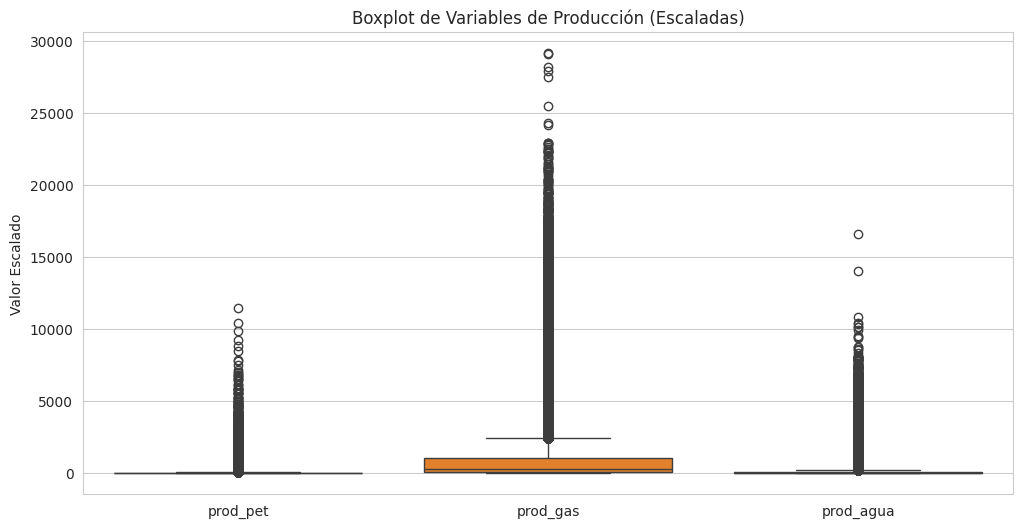

In [ ]:
# Outliers de Variables de Producci√≥n: 'prod_pet', 'prod_gas', 'prod_agua'

plt.figure(figsize=(12, 6))
sns.boxplot(data=df2_copy[['prod_pet', 'prod_gas', 'prod_agua']])
plt.title('Boxplot de Variables de Producci√≥n (Escaladas)')
plt.ylabel('Valor Escalado')
plt.show()


In [ ]:
# Identificar Outliers de las Variables de Producci√≥n

import pandas as pd
def find_outliers_iqr(df2_copy, columns):

    outlier_indices = {}
    for col in columns:
        Q1 = df2_copy[col].quantile(0.25)
        Q3 = df2_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Encontrar los √≠ndices de los outliers
        outlier_indices[col] = df2_copy[(df2_copy[col] < lower_bound) | (df2_copy[col] > upper_bound)].index.tolist()
    return outlier_indices

# Variables a analizar para outliers
outlier_vars = ['prod_pet', 'prod_gas', 'prod_agua']

# Identificar outliers usando la funci√≥n
outliers_dict = find_outliers_iqr(df2_copy, outlier_vars)

# Lista para almacenar el total de outliers encontrados (contando √≠ndices √∫nicos)
all_outlier_indices = []

# Iterar sobre las columnas num√©ricas para identificar outliers
for col, indices in outliers_dict.items():
    print(f"Outliers encontrados en '{col}' usando IQR: {len(indices)}")
    all_outlier_indices.extend(indices)

# Calcular el total de puntos de datos
total_data_points = df2_copy.shape[0]

# Calcular el total de outliers √∫nicos (contando cada fila con al menos un outlier una vez)
total_unique_outliers = len(set(all_outlier_indices))

# Calcular el porcentaje de outliers sobre el total de puntos de datos
percentage_outliers = (total_unique_outliers / total_data_points) * 100 if total_data_points > 0 else 0

# Imprimir los resultados
print("\nResultados del An√°lisis de Outliers:")
print(f"Total de outliers identificados (√≠ndices √∫nicos): {total_unique_outliers}")
print(f"Total de datos en el DataFrame procesado: {total_data_points}")
print(f"Porcentaje de outliers sobre el total de datos: {percentage_outliers:.2f}%")

Outliers encontrados en 'prod_pet' usando IQR: 27153
Outliers encontrados en 'prod_gas' usando IQR: 20584
Outliers encontrados en 'prod_agua' usando IQR: 24161

Resultados del An√°lisis de Outliers:
Total de outliers identificados (√≠ndices √∫nicos): 44634
Total de datos en el DataFrame procesado: 173541
Porcentaje de outliers sobre el total de datos: 25.72%


Para las Variables de Producci√≥n (prod_pet, prod_gas, prod_agua), donde tenemos un 25.72% de outliers identificados por IQR, la decisi√≥n de c√≥mo manejarlos es crucial, ya que estos valores extremos pueden tener un impacto significativo en los algoritmos de clustering.

Por este motivo decidimos realizar una **transformaci√≥n Logar√≠tmica y aplicar StandardScaler** para asi reducir a influencia de outliers pero conservar los datos.

*(Apicado en la codificaci√≥n de Variables N√∫mericas)*

**Outliers de Variables Geogr√°ficas**

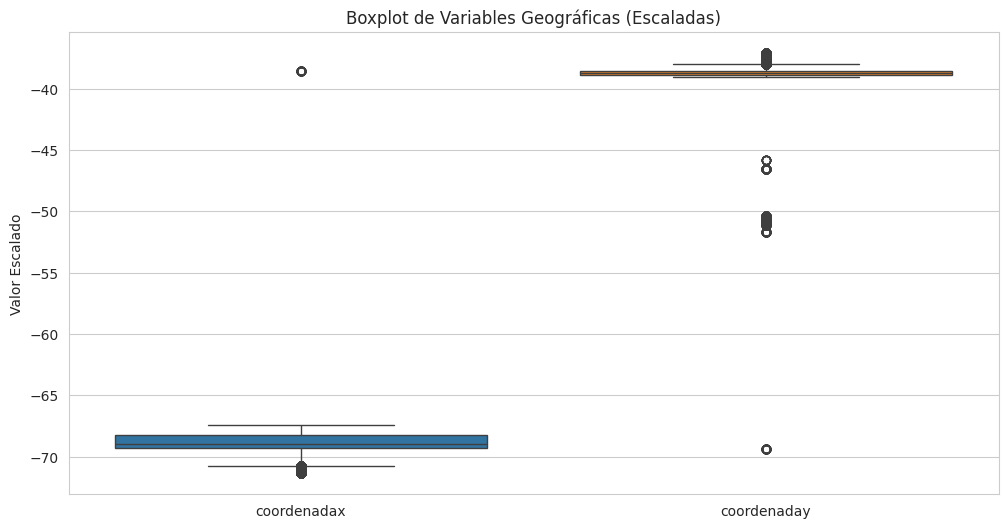

In [ ]:
# Outliers de Variables de Geogr√°ficas

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(data=df2_copy[['coordenadax', 'coordenaday']])
plt.title('Boxplot de Variables Geogr√°ficas (Escaladas)')
plt.ylabel('Valor Escalado')
plt.show()

In [ ]:
# Identificar Outliers de las Variables Geogr√°ficas

import pandas as pd
def find_outliers_iqr(df2_copy, columns):

    outlier_indices = {}
    for col in columns:
        Q1 = df2_copy[col].quantile(0.25)
        Q3 = df2_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Encontrar los √≠ndices de los outliers
        outlier_indices[col] = df2_copy[(df2_copy[col] < lower_bound) | (df2_copy[col] > upper_bound)].index.tolist()
    return outlier_indices

# Variables a analizar para outliers geogr√°ficos
outlier_vars_geo = ['coordenadax', 'coordenaday']

# Identificar outliers usando la funci√≥n
outliers_dict_geo = find_outliers_iqr(df2_copy, outlier_vars_geo)

# Lista para almacenar el total de outliers encontrados (contando √≠ndices √∫nicos)
all_outlier_indices_geo = []

# Iterar sobre las columnas num√©ricas para identificar outliers
for col, indices in outliers_dict_geo.items():
    print(f"Outliers encontrados en '{col}' usando IQR: {len(indices)}")
    all_outlier_indices_geo.extend(indices)

# Calcular el total de puntos de datos
total_data_points_geo = df2_copy.shape[0]

# Calcular el total de outliers √∫nicos (contando cada fila con al menos un outlier una vez)
total_unique_outliers_geo = len(set(all_outlier_indices_geo))

# Calcular el porcentaje de outliers sobre el total de puntos de datos
percentage_outliers_geo = (total_unique_outliers_geo / total_data_points_geo) * 100 if total_data_points_geo > 0 else 0

# Imprimir los resultados
print("\nResultados del An√°lisis de Outliers Geogr√°ficos:")
print(f"Total de outliers identificados en columnas geogr√°ficas: {total_unique_outliers_geo}")
print(f"Total de datos en el DataFrame procesado: {total_data_points_geo}")
print(f"Porcentaje de outliers sobre el total de datos geogr√°ficos: {percentage_outliers_geo:.2f}%")

Outliers encontrados en 'coordenadax' usando IQR: 2859
Outliers encontrados en 'coordenaday' usando IQR: 19700

Resultados del An√°lisis de Outliers Geogr√°ficos:
Total de outliers identificados en columnas geogr√°ficas: 19700
Total de datos en el DataFrame procesado: 173541
Porcentaje de outliers sobre el total de datos geogr√°ficos: 11.35%


Las coordenadas geogr√°ficas no son m√©tricas de "rendimiento" como la producci√≥n de gas o petr√≥leo. Son ubicaciones. Un pozo ubicado lejos del "centro" de la mayor√≠a de los pozos no es necesariamente un "error" o un valor an√≥malo en el mismo sentido que una producci√≥n extremadamente alta o baja.

Por este motivo decidimos mantener estos "outliers" geogr√°ficos. Eliminarlos ser√≠a contraproducente para el objetivo de nuestro an√°lisis: Descubrir Patrones Geogr√°ficos.

#### 3. Escalado de Variables Num√©ricas (StandardScaler)  

Usamos **Z-score** para escalar variables de producci√≥n `prod_gas`, `prod_pet` y `prod_agua`, y las variables geograficas `coordenadax` y `coordenaday` son variables n√∫mericas por lo que aplicaremos el StandardScaler.

In [ ]:
# Variables N√∫mericas
numeric_cols = df2_copy.select_dtypes(include=np.number).columns.tolist()
print("Variables num√©ricas:")
numeric_cols

Variables num√©ricas:


['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

#### 4. Codificaci√≥n de Variables Categ√≥ricas (OneHotEncoder)  

Convertimos variables categ√≥ricas, como `'cuenca'`, `'provincia'`, `'sub_tipo_recurso'`, `'subclasificacion'` a formato num√©rico utilizando OneHotEncoder.

In [ ]:
# Variables Categ√≥ricas
object_cols = df2_copy.select_dtypes(include='object').columns.tolist()
print("Variables categ√≥ricas (Object):")
object_cols

Variables categ√≥ricas (Object):


['cuenca', 'provincia', 'sub_tipo_recurso', 'subclasificacion']

In [ ]:
# Identificar columnas num√©ricas y categ√≥ricas
numerical_features_2 = [col for col in df2_copy.columns if df2_copy[col].dtype in ['int32', 'int64', 'float64']]
categorical_features_2 = [col for col in df2_copy.columns if df2_copy[col].dtype in ['object']]

print("\nColumnas Num√©ricas identificadas:", numerical_features_2)
print("Columnas Categ√≥ricas identificadas:", categorical_features_2)


Columnas Num√©ricas identificadas: ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']
Columnas Categ√≥ricas identificadas: ['cuenca', 'provincia', 'sub_tipo_recurso', 'subclasificacion']


In [ ]:
# Dividir columnas num√©ricas de producci√≥n y geograficas
production_features = ['prod_pet', 'prod_gas', 'prod_agua']
geographic_features = ['coordenadax', 'coordenaday']

In [ ]:
# Transformaci√≥n logar√≠tmica para las variables de producci√≥n
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [ ]:
# Preprocesamiento con Pipeline
preprocessor_2 = ColumnTransformer(
    transformers=[
        # Aplicar logaritmo y luego StandardScaler a las variables de producci√≥n
        ('prod_num_log_scaled',
         Pipeline([
             ('log', log_transformer),
             ('scaler', StandardScaler())
         ]),
         ['prod_pet', 'prod_gas', 'prod_agua']),

        # Aplicar StandardScaler a las variables geogr√°ficas
        ('geo_num_scaled', StandardScaler(), ['coordenadax', 'coordenaday']),

        # Aplicar OneHotEncoder a las variables categ√≥ricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_2)
    ],
    remainder='passthrough'
)

# Aplicar el preprocesamiento
df2_processed_array = preprocessor_2.fit_transform(df2_copy)

# Obtener los nombres de las caracter√≠sticas despu√©s del preprocesamiento
feature_names_prod = [f"log_scaled_{col}" for col in ['prod_pet', 'prod_gas', 'prod_agua']]
feature_names_geo = [f"scaled_{col}" for col in ['coordenadax', 'coordenaday']]
feature_names_cat = preprocessor_2.named_transformers_['cat'].get_feature_names_out(categorical_features_2)

# Combinar los nombres de las columnas procesadas
processed_feature_names_2 = feature_names_prod + feature_names_geo + list(feature_names_cat)

# Convierte el array procesado de nuevo en un DataFrame
df2_processed = pd.DataFrame(df2_processed_array, columns=processed_feature_names_2, index=df2_copy.index)

print(f"Dimensiones de los datos procesados: {df2_processed.shape}")
print(f"Columnas del DataFrame procesado: {df2_processed.columns.tolist()}")

Dimensiones de los datos procesados: (173541, 20)
Columnas del DataFrame procesado: ['log_scaled_prod_pet', 'log_scaled_prod_gas', 'log_scaled_prod_agua', 'scaled_coordenadax', 'scaled_coordenaday', 'cuenca_AUSTRAL', 'cuenca_GOLFO SAN JORGE', 'cuenca_NEUQUINA', 'provincia_Chubut', 'provincia_Mendoza', 'provincia_Neuqu√©n', 'provincia_Rio Negro', 'provincia_Santa Cruz', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT', 'subclasificacion_AVANZADA', 'subclasificacion_DESARROLLO', 'subclasificacion_EXPLORACION', 'subclasificacion_EXPLORATORIO PROFUNDO', 'subclasificacion_EXTENSION']


In [ ]:
df2_processed.isnull().sum()

log_scaled_prod_pet                       0
log_scaled_prod_gas                       2
log_scaled_prod_agua                      0
scaled_coordenadax                        0
scaled_coordenaday                        0
cuenca_AUSTRAL                            0
cuenca_GOLFO SAN JORGE                    0
cuenca_NEUQUINA                           0
provincia_Chubut                          0
provincia_Mendoza                         0
provincia_Neuqu√©n                         0
provincia_Rio Negro                       0
provincia_Santa Cruz                      0
sub_tipo_recurso_SHALE                    0
sub_tipo_recurso_TIGHT                    0
subclasificacion_AVANZADA                 0
subclasificacion_DESARROLLO               0
subclasificacion_EXPLORACION              0
subclasificacion_EXPLORATORIO PROFUNDO    0
subclasificacion_EXTENSION                0
dtype: int64

In [ ]:
# Eliminar los valores nulos de 'log_scaled_prod_gas'

df2_processed.dropna(subset=['log_scaled_prod_gas'], inplace=True)
print("Nulos despu√©s de eliminar nulos en 'log_scaled_prod_gas':")
print(df2_processed.isnull().sum())

Nulos despu√©s de eliminar nulos en 'log_scaled_prod_gas':
log_scaled_prod_pet                       0
log_scaled_prod_gas                       0
log_scaled_prod_agua                      0
scaled_coordenadax                        0
scaled_coordenaday                        0
cuenca_AUSTRAL                            0
cuenca_GOLFO SAN JORGE                    0
cuenca_NEUQUINA                           0
provincia_Chubut                          0
provincia_Mendoza                         0
provincia_Neuqu√©n                         0
provincia_Rio Negro                       0
provincia_Santa Cruz                      0
sub_tipo_recurso_SHALE                    0
sub_tipo_recurso_TIGHT                    0
subclasificacion_AVANZADA                 0
subclasificacion_DESARROLLO               0
subclasificacion_EXPLORACION              0
subclasificacion_EXPLORATORIO PROFUNDO    0
subclasificacion_EXTENSION                0
dtype: int64


### ü§ñ Aplicaci√≥n de Algoritmos de Clustering

Implementaremos K-Means y DBSCAN para el Dataset 2.

**Reducci√≥n de dimensionalidad - PCA**

Debido a la gran cantidad de dimensiones del Dataset2 (20 en total), una de las pr√°cticas para realizar un clustering es reducir la dimensionalidad.

Se llevar√° a cabo el metodo PCA para la reducci√≥n de dimensionalidad de columnas importantes para nuestro analisis.

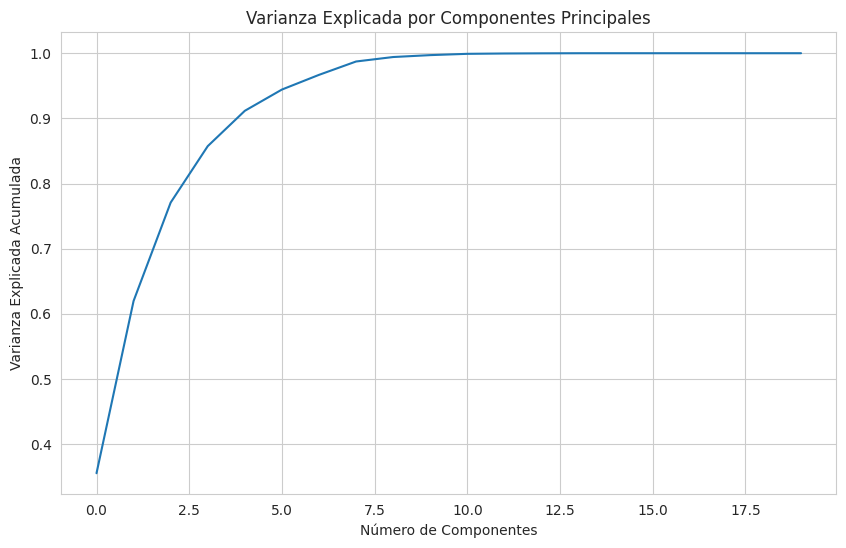

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

 # Copia de df2_processed
df2_clusters = df2_processed.copy()

# Imputar valores perdidos en ‚Äúlog_scaled_prod_gas‚Äù con la media
mean_log_scaled_prod_gas = df2_clusters['log_scaled_prod_gas'].mean()
df2_clusters['log_scaled_prod_gas'].fillna(mean_log_scaled_prod_gas, inplace=True)


# Determinar el n√∫mero √≥ptimo de componentes para PCA
pca = PCA().fit(df2_clusters)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid(True)
plt.show()

In [ ]:
# Elegir cu√°ntos componentes explican una varianza aceptable
n_components_pca = 10

# Aplicar PCA con el n√∫mero de componentes elegido
pca_final = PCA(n_components=n_components_pca, random_state=42)
df2_clusters_pca = pca_final.fit_transform(df2_clusters)

# Crea un DataFrame con los componentes PCA para el clustering
df2_pca_processed = pd.DataFrame(df2_clusters_pca, index=df2_clusters.index,
                                columns=[f'PC_{i+1}' for i in range(n_components_pca)])

print(f"\nDimensiones de los datos despu√©s de PCA: {df2_pca_processed.shape}")
print(f"Varianza explicada por los {n_components_pca} componentes: {pca_final.explained_variance_ratio_.sum():.2f}")


Dimensiones de los datos despu√©s de PCA: (173539, 10)
Varianza explicada por los 10 componentes: 1.00


In [ ]:
# Verificar el tipo de datos en df2_pca_processed
df2_pca_processed.dtypes

PC_1     float64
PC_2     float64
PC_3     float64
PC_4     float64
PC_5     float64
PC_6     float64
PC_7     float64
PC_8     float64
PC_9     float64
PC_10    float64
dtype: object

**Transformar Datos a `float32`**

In [ ]:
# Convierte los tipos de datos a float32 para optimizar el uso de memoria, como lo hac√≠as antes
for col in df2_pca_processed.select_dtypes(include=[np.float64]).columns:
    df2_pca_processed[col] = df2_pca_processed[col].astype(np.float32)

print(f"Uso de memoria despu√©s de float32: {df2_pca_processed.memory_usage(deep=True).sum() / (1024**3):.4f} GB")

Uso de memoria despu√©s de float32: 0.0078 GB


#### üìä K-Means  

Aplicamos K-Means y determinamos el n√∫mero √≥ptimo de clusters con:

- **M√©todo del Codo**  
- **Coeficiente de Silueta**

Ambos m√©todos permiten evaluar la cohesi√≥n y separaci√≥n de los grupos.

In [ ]:
# Ignorar FutureWarning de KMeans que a veces aparece con n_init por defecto
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Preparaci√≥n de los datos para K-Means ---
# Seleccionamos solo las columnas de los componentes PCA
pca_components_for_kmeans = df2_pca_processed.loc[:, ['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10']]

print(f"\n--- Preparando los datos para K-Means ---")
print(f"Dimensiones de los datos para K-Means (componentes PCA): {pca_components_for_kmeans.shape}")
print(f"Uso de memoria de los datos para K-Means: {pca_components_for_kmeans.memory_usage(deep=True).sum() / (1024**3):.2f} GB")
print(f"Tipo de datos (dtype) de las componentes PCA: {pca_components_for_kmeans.dtypes.unique()}")


--- Preparando los datos para K-Means ---
Dimensiones de los datos para K-Means (componentes PCA): (173539, 10)
Uso de memoria de los datos para K-Means: 0.01 GB
Tipo de datos (dtype) de las componentes PCA: [dtype('float32')]



Ejecutando M√©todo del Codo para K-Means...


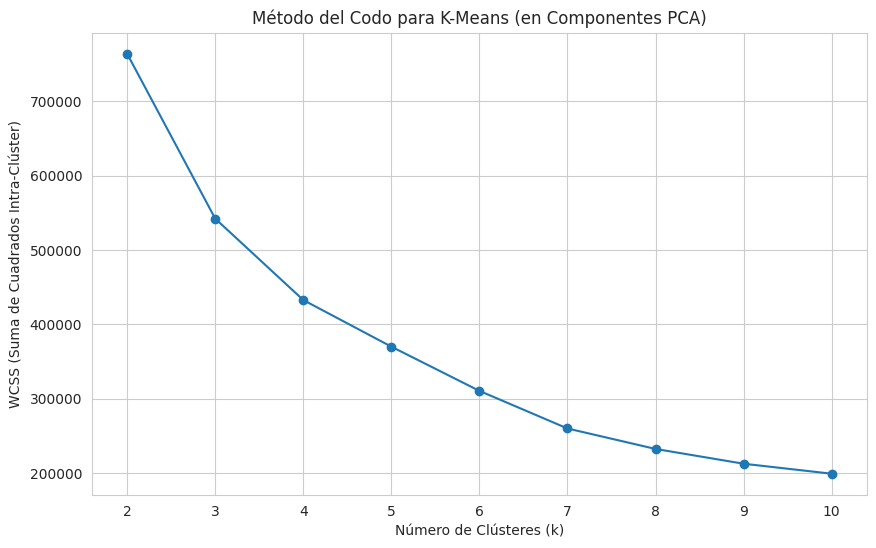

In [ ]:
# 1. M√©todo del Codo para encontrar el k √≥ptimo
print("\nEjecutando M√©todo del Codo para K-Means...")
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(pca_components_for_kmeans)
    wcss.append(kmeans_model.inertia_)

# Graficar el M√©todo del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('M√©todo del Codo para K-Means (en Componentes PCA)')
plt.xlabel('N√∫mero de Cl√∫steres (k)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Cl√∫ster)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Bas√°ndonos en la forma del "codo", el n√∫mero √≥ptimo de clusters (k) estar√≠a probablemente en 3 o 4,  con una ligera preferencia por `k=3` como el "codo" m√°s marcado.


Calculando Coeficiente de Silueta para K-Means...


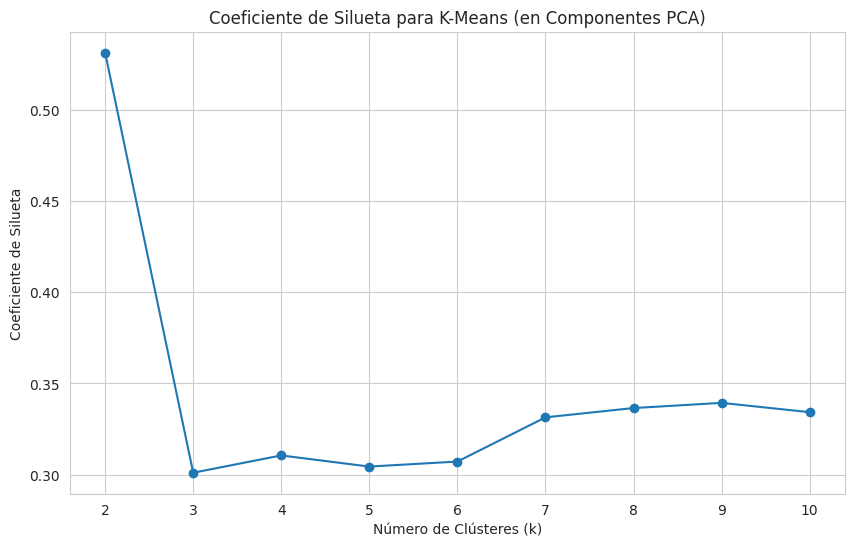

Valores de Coeficiente de Silueta por k: {2: np.float32(0.53147006), 3: np.float32(0.30098775), 4: np.float32(0.3104751), 5: np.float32(0.30436084), 6: np.float32(0.3071123), 7: np.float32(0.33137143), 8: np.float32(0.33648384), 9: np.float32(0.3393159), 10: np.float32(0.33420676)}


In [ ]:
# 2. Coeficiente de Silueta para encontrar el k √≥ptimo
print("\nCalculando Coeficiente de Silueta para K-Means...")
silhouette_scores = []

for k in k_range:
    if k == 1:
        silhouette_scores.append(np.nan)
        continue

    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_model.fit_predict(pca_components_for_kmeans)

    if len(np.unique(cluster_labels)) > 1:
        score = silhouette_score(pca_components_for_kmeans, cluster_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)

# Graficar el Coeficiente de Silueta
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Coeficiente de Silueta para K-Means (en Componentes PCA)')
plt.xlabel('N√∫mero de Cl√∫steres (k)')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("Valores de Coeficiente de Silueta por k:", {k_val: score for k_val, score in zip(k_range, silhouette_scores)})

In [ ]:
# Aplicar K-Means con el k √≥ptimo elegido
k_optimo_final = 2
print(f"\nEl n√∫mero de cl√∫steres (k) para K-Means es: {k_optimo_final}")

print(f"\nAplicando K-Means con el k √≥ptimo final elegido: {k_optimo_final}")
kmeans_final = KMeans(n_clusters=k_optimo_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(pca_components_for_kmeans)

# Asignar los cl√∫steres al DataFrame principal df2_pca_processed
df2_pca_processed['kmeans_cluster'] = cluster_labels

print(f"\nDistribuci√≥n de cl√∫steres K-Means con k={k_optimo_final}:")
print(df2_pca_processed['kmeans_cluster'].value_counts().sort_index())


El n√∫mero de cl√∫steres (k) para K-Means es: 2

Aplicando K-Means con el k √≥ptimo final elegido: 2

Distribuci√≥n de cl√∫steres K-Means con k=2:
kmeans_cluster
0    162354
1     11185
Name: count, dtype: int64


El valor m√°s alto del Coeficiente de Silueta se obtiene cuando` k = 2`, con un valor de 0.53147006.

Esto contrasta con la posible elecci√≥n de k=3 o k=4 que se pod√≠a inferir del m√©todo del codo. Sin embargo,nos vamos a basar √∫nicamente en el Coeficiente de Silueta, k=2. Esto se debe a que buscamos un equilibrio entre las m√©tricas y la interpretabilidad de los clusters para este an√°lisis.

#### üåê DBSCAN  

Exploramos este algoritmo basado en densidad. Las claves:

- **eps**: Radio de vecindad  
- **min_samples**: M√≠nimo de puntos por vecindad  

Utilizamos el **gr√°fico de la distancia al K-vecino m√°s cercano** para elegir un buen valor de `eps`.

In [ ]:
# Implementaci√≥n de DBSCAN
print("\n--- Implementando DBSCAN ---")

X_dbscan = df2_pca_processed.drop(columns=['kmeans_cluster'], errors='ignore').copy()

# Definir min_samples
min_samples_dbscan2_final = 2 * X_dbscan.shape[1]
print(f"Min_samples para DBSCAN (usado en gr√°fico y final): {min_samples_dbscan2_final}")


--- Implementando DBSCAN ---
Min_samples para DBSCAN (usado en gr√°fico y final): 20


In [ ]:
# Estimar eps para DBSCAN usando el gr√°fico de K-distancia
print("Generando Gr√°fico de Distancia K-Vecino m√°s Cercano para DBSCAN ...")
neighbors = NearestNeighbors(n_neighbors=min_samples_dbscan2_final)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

Generando Gr√°fico de Distancia K-Vecino m√°s Cercano para DBSCAN ...


In [ ]:
# Ordenar las distancias
distances_sorted = np.sort(distances[:, min_samples_dbscan2_final-1], axis=0)

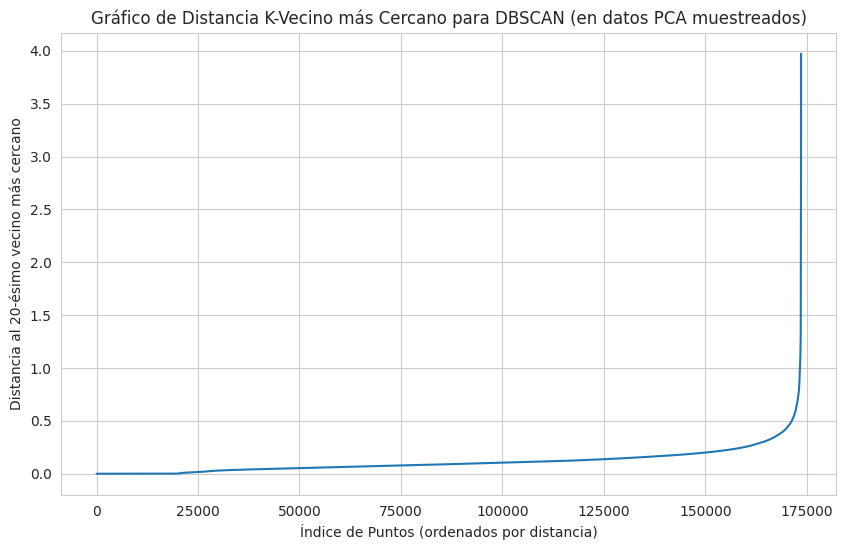

In [ ]:
# Gr√°fico de Distancia K-Vecino m√°s Cercano para DBSCAN
plt.figure(figsize=(10, 6))
plt.plot(distances_sorted)
plt.xlabel("√çndice de Puntos (ordenados por distancia)")
plt.ylabel(f"Distancia al {min_samples_dbscan2_final}-√©simo vecino m√°s cercano")
plt.title("Gr√°fico de Distancia K-Vecino m√°s Cercano para DBSCAN (en datos PCA muestreados)")
plt.grid(True)
plt.show()

Bas√°ndome en la visualizaci√≥n, sugiere un eps en torno a **0.6 - 0.8** para DBSCAN.

Elegimos `eps = 0.8` porque es la opci√≥n que mantiene la misma cantidad de clusters pero con menor cantidad de outliers.

In [ ]:
# Selecci√≥n de eps √≥ptimo
eps_optimo_dbscan2 = 0.8
print(f"\nSe ha definido un eps inicial de {eps_optimo_dbscan2}. ")


Se ha definido un eps inicial de 0.8. 


In [ ]:
# Aplicar DBSCAN con los par√°metros seleccionados
dbscan_final = DBSCAN(eps=eps_optimo_dbscan2, min_samples=min_samples_dbscan2_final)

In [ ]:
# Asignar el resultado al DataFrame df2_pca_processed
df2_pca_processed['dbscan_cluster'] = dbscan_final.fit_predict(X_dbscan)
print(f"\nSe ha ejecutado DBSCAN con eps = {eps_optimo_dbscan2} y min_samples = {min_samples_dbscan2_final}.")


Se ha ejecutado DBSCAN con eps = 0.8 y min_samples = 20.


In [ ]:
# Verificar el conteo de cl√∫steres en el DataFrame principal
print("\nConteo de elementos por cl√∫ster DBSCAN:")
print(df2_pca_processed['dbscan_cluster'].value_counts().sort_index())
print(f"Nota: El cl√∫ster -1 representa outliers (ruido).")


Conteo de elementos por cl√∫ster DBSCAN:
dbscan_cluster
-1       183
 0     99682
 1      5800
 2     17829
 3      1917
 4      3209
 5     27005
 6       333
 7      1020
 8       288
 9      9210
 10     1840
 11       20
 12     1372
 13      664
 14     1092
 15      117
 16      229
 17      102
 18      111
 19      133
 20      195
 21      857
 22       92
 23      110
 24       39
 25       70
 26       20
Name: count, dtype: int64
Nota: El cl√∫ster -1 representa outliers (ruido).


#### üìà GMM (Gaussian Mixture Models)

Aplicamos Modelos de Mezcla Gaussiana, una t√©cnica probabil√≠stica que asume que los datos provienen de m√∫ltiples distribuciones normales.

- Asignaci√≥n probabil√≠stica de pertenencia a cada cluster  
- Estimaci√≥n de par√°metros mediante el algoritmo EM (Expectation-Maximization)

Evaluamos el n√∫mero √≥ptimo de componentes utilizando los criterios:  
- **BIC** (Bayesian Information Criterion)  
- **AIC** (Akaike Information Criterion)

Estos indicadores penalizan la complejidad del modelo y ayudan a evitar el sobreajuste.


In [ ]:
# Implementaci√≥n de GMM
print("\n--- Implementando GMM ---")

# Preparaci√≥n de los datos para GMM
# Seleccionamos solo las columnas de los componentes PCA
pca_components_for_gmm = df2_pca_processed.loc[:, ['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10']]


--- Implementando GMM ---


In [ ]:
# Determinar el n√∫mero √≥ptimo de componentes para GMM
n_components_range = range(1, 11)
aic = []
bic = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=10)
    gmm.fit(pca_components_for_gmm)
    aic.append(gmm.aic(pca_components_for_gmm))
    bic.append(gmm.bic(pca_components_for_gmm))

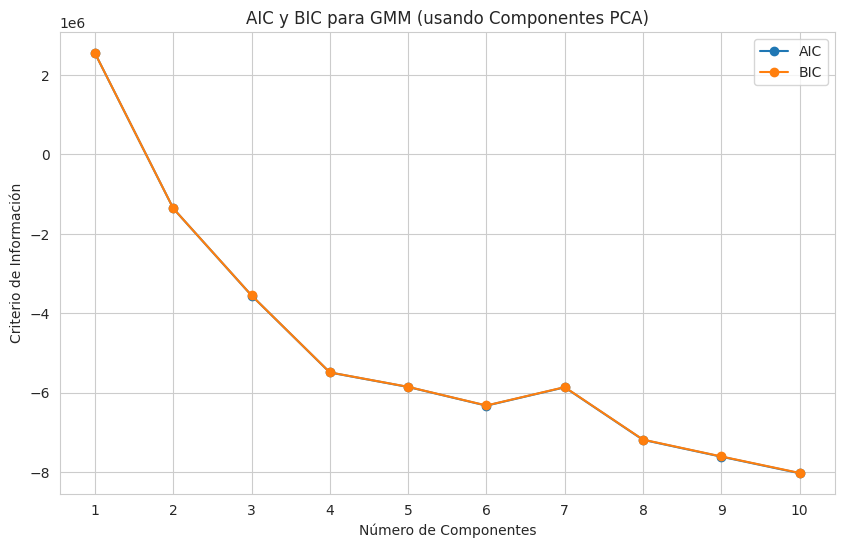

In [ ]:
# Visualizaci√≥n de AIC y BIC para GMM
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, aic, label='AIC', marker='o')
plt.plot(n_components_range, bic, label='BIC', marker='o')
plt.xlabel("N√∫mero de Componentes")
plt.ylabel("Criterio de Informaci√≥n")
plt.title("AIC y BIC para GMM (usando Componentes PCA)")
plt.legend()
plt.xticks(n_components_range)
plt.show()

Bas√°ndonos en este gr√°fico, el valor ideal para `n_optimo_gmm2` es **2**, ya que es el n√∫mero de componentes que minimiza el Criterio de Informaci√≥n Bayesiano (BIC). Esto sugiere que un modelo GMM con 2 componentes es el que mejor explica los datos con la menor complejidad.

In [ ]:
# N√∫mero de componentes
n_optimo_gmm2 = 2
print(f"\nN√∫mero de componentes √≥ptimo para GMM (elegido manualmente): {n_optimo_gmm2}")


N√∫mero de componentes √≥ptimo para GMM (elegido manualmente): 2


In [ ]:
# Aplicar GMM con el n√∫mero √≥ptimo de componentes seleccionado
gmm2 = GaussianMixture(n_components=n_optimo_gmm2, random_state=42, n_init=10)
gmm2.fit(pca_components_for_gmm)

GaussianMixture(n_components=2, n_init=10, random_state=42)

In [ ]:
# Asignar los cl√∫steres GMM a tu DataFrame principal df2_pca_processed
df2_pca_processed['gmm_cluster'] = gmm2.predict(pca_components_for_gmm)

print(f"\nSe ha ejecutado GMM con {n_optimo_gmm2} componentes.")
print(f"La columna 'gmm_cluster' ha sido a√±adida a df2_pca_processed.")
print(f"Conteo de elementos por cluster GMM:\n{df2_pca_processed['gmm_cluster'].value_counts().sort_index()}")


Se ha ejecutado GMM con 2 componentes.
La columna 'gmm_cluster' ha sido a√±adida a df2_pca_processed.
Conteo de elementos por cluster GMM:
gmm_cluster
0    135257
1     38282
Name: count, dtype: int64


### üìâ An√°lisis Exploratorio y Visualizaci√≥n de Clusters  

Visualizamos los resultados y analizamos promedios por cluster.

#### üìå K-Means  

- An√°lisis de Clusters K-Means (Dataset2)

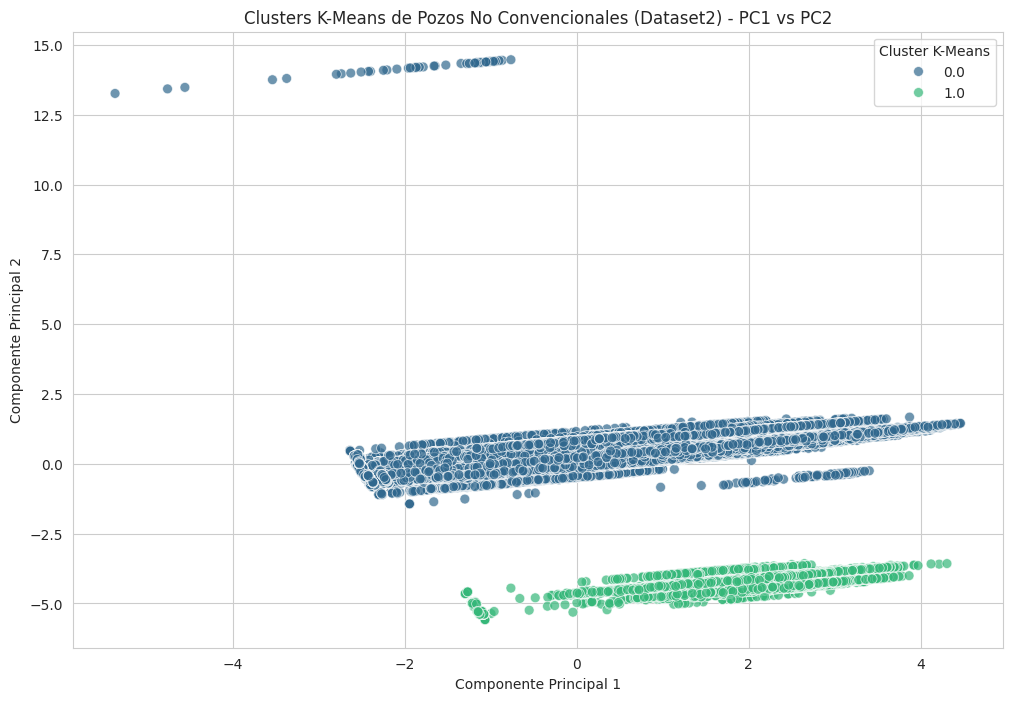

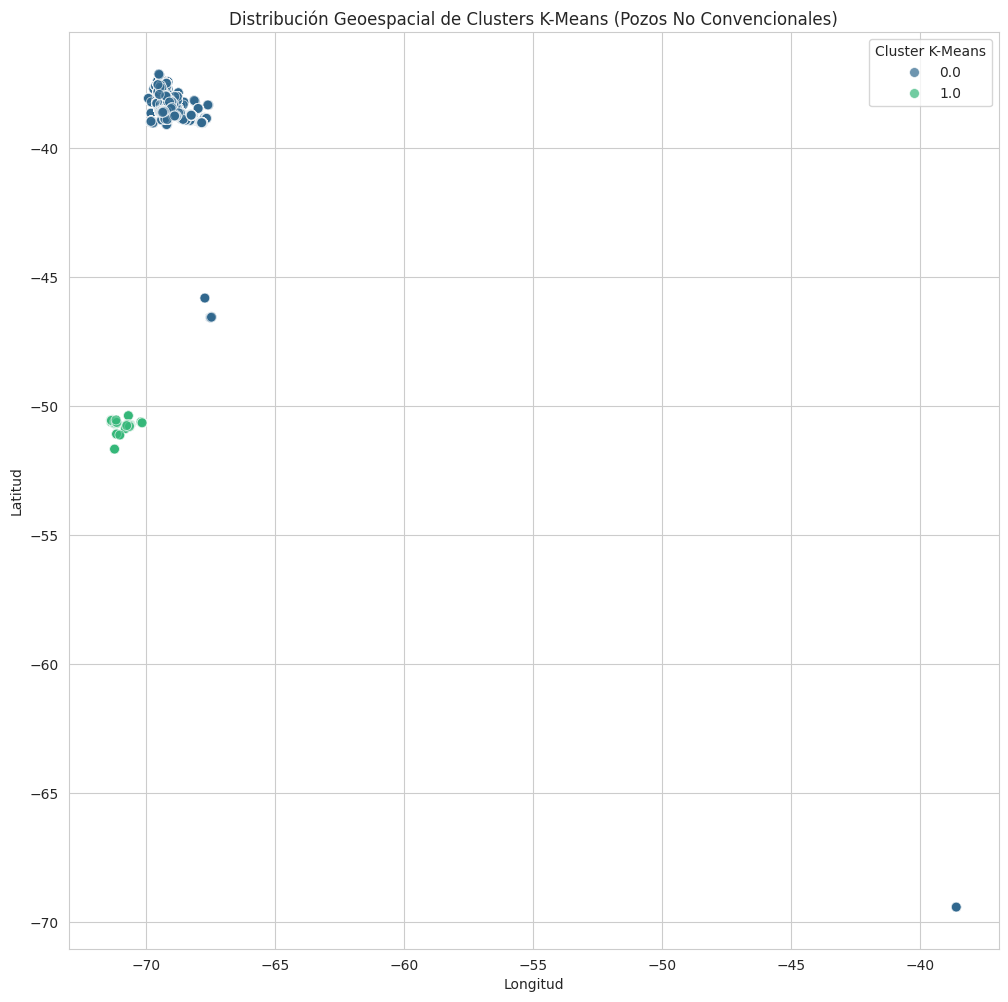


Caracter√≠sticas promedio por Cluster (K-Means - Dataset2) - Valores Originales:
                   prod_gas   prod_pet   prod_agua  coordenaday  coordenadax
kmeans_cluster                                                              
0.0             1087.937815  55.618457  147.218066   -38.688657   -68.746981
1.0              729.112823  23.070713   60.983357   -50.736652   -70.784902

Proporciones de Variables Categ√≥ricas por Cluster (K-Means - Dataset2):

--- Cluster 0.0 ---
  cuenca:
cuenca
NEUQUINA           1.0
GOLFO SAN JORGE    0.0
Name: proportion, dtype: float64
  provincia:
provincia
Neuqu√©n       0.87
Rio Negro     0.12
Mendoza       0.00
Santa Cruz    0.00
Chubut        0.00
Name: proportion, dtype: float64
  sub_tipo_recurso:
sub_tipo_recurso
TIGHT    0.8
SHALE    0.2
Name: proportion, dtype: float64
  subclasificacion:
subclasificacion
DESARROLLO               0.89
AVANZADA                 0.05
EXPLORACION              0.04
EXTENSION                0.01
EXPLORATORIO P

In [ ]:
# An√°lisis de Clusters K-Means (Dataset2)

# Crear un DataFrame con las columnas originales relevantes y los resultados de clusters con PCA
df2_with_clusters = df2_copy.copy()

# Fusionar las etiquetas de cl√∫ster y los componentes PCA
df2_with_clusters = df2_with_clusters.merge(
    df2_pca_processed[['PC_1', 'PC_2', 'dbscan_cluster', 'gmm_cluster', 'kmeans_cluster']],
    left_index=True,
    right_index=True,
    how='left'
)

# Seleccionar columnas existentes para la visualizaci√≥n.
df2_with_clusters['pca1_viz_plot'] = df2_with_clusters['PC_1']
df2_with_clusters['pca2_viz_plot'] = df2_with_clusters['PC_2']

# Visualizaci√≥n de Clusters (K-Means) en PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='kmeans_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters K-Means de Pozos No Convencionales (Dataset2) - PC1 vs PC2')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.grid(True)
plt.show()

# Visualizaci√≥n Geoespacial de Clusters (K-Means)
plt.figure(figsize=(12, 12))
sns.scatterplot(x='coordenadax', y='coordenaday', hue='kmeans_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Distribuci√≥n Geoespacial de Clusters K-Means (Pozos No Convencionales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster K-Means')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# Caracter√≠sticas promedio por Cluster (K-Means)
print("\nCaracter√≠sticas promedio por Cluster (K-Means - Dataset2) - Valores Originales:")

# Columnas num√©ricas originales relevantes para el an√°lisis de clusters
numerical_cols_for_analysis = ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

# Revisar de que las columnas existen en df2_with_clusters
existing_numerical_cols = [col for col in numerical_cols_for_analysis if col in df2_with_clusters.columns]

if not existing_numerical_cols:
    print("Advertencia: Ninguna de las columnas num√©ricas especificadas se encontr√≥ en el DataFrame para el an√°lisis de promedios.")
else:
    cluster_summary_kmeans2 = df2_with_clusters.groupby('kmeans_cluster')[
        existing_numerical_cols
    ].mean()
    print(cluster_summary_kmeans2)

# An√°lisis de proporciones de variables categ√≥ricas por cluster (K-Means)
print("\nProporciones de Variables Categ√≥ricas por Cluster (K-Means - Dataset2):")
# Revisar la lista 'categorical_features_2' est√° definida
if 'categorical_features_2' not in locals() and 'categorical_features_2' not in globals():
    print("Advertencia: La lista 'categorical_features_2' no est√° definida. No se puede realizar el an√°lisis de variables categ√≥ricas.")
else:
    # Revisar que las columnas categ√≥ricas existen en df2_with_clusters
    existing_categorical_cols = [col for col in categorical_features_2 if col in df2_with_clusters.columns]

    if not existing_categorical_cols:
        print("Advertencia: Ninguna de las columnas categ√≥ricas especificadas se encontr√≥ en el DataFrame para el an√°lisis de proporciones.")
    else:
        for cluster_id in sorted(df2_with_clusters['kmeans_cluster'].unique()):
            cluster_data = df2_with_clusters[df2_with_clusters['kmeans_cluster'] == cluster_id]
            print(f"\n--- Cluster {cluster_id} ---")
            for cat_col in existing_categorical_cols:
                if not cluster_data[cat_col].empty:
                    print(f"  {cat_col}:\n{cluster_data[cat_col].value_counts(normalize=True).round(2)}")
                else:
                    print(f"  {cat_col}: No hay datos para este cl√∫ster.")

#### **An√°lisis de Clusters K-Means (Dataset2: Producci√≥n de Pozos No Convencionales)**

El modelo K-Means (k=2) permiti√≥ segmentar los pozos de gas no convencionales en Argentina en dos grupos bien definidos, diferenciados por ubicaci√≥n geogr√°fica, tipo de recurso y niveles de productividad.

**Cluster 0.0 ‚Äì Alta Productividad en Cuenca Neuquina**

* **Ubicaci√≥n:** 100% de los pozos est√°n en la Cuenca Neuquina, principalmente en Neuqu√©n (87%) y R√≠o Negro (12%).
* **Tipo de Recurso:** Mayoritariamente TIGHT (80%) y en menor medida SHALE (20%).
* **Estado de Desarrollo:** 89% de los pozos est√°n en fase de desarrollo.
* **Producci√≥n:** Presenta las producciones promedio m√°s altas de gas, petr√≥leo y agua. Este patr√≥n es consistente con la alta productividad de la formaci√≥n Vaca Muerta.

**Cluster 1.0 ‚Äì Baja Productividad en Cuenca Austral**

* **Ubicaci√≥n:** Todos los pozos se ubican en la Cuenca Austral, provincia de Santa Cruz.
* **Tipo de Recurso:** 100% TIGHT.
* **Estado de Desarrollo:** 82% en fase de desarrollo.
* **Producci√≥n:** Significativamente m√°s baja en comparaci√≥n con el Cluster 0.0 en todas las variables de salida (gas, petr√≥leo y agua).

---

**Conclusi√≥n General**

El clustering K-Means permiti√≥ identificar dos perfiles productivos claros y geogr√°ficamente coherentes dentro del universo de pozos no convencionales: por un lado, pozos de alta productividad en la Cuenca Neuquina con explotaci√≥n mixta de recursos; por otro, pozos con menor rendimiento en la Cuenca Austral, centrados exclusivamente en tight gas. Esta segmentaci√≥n proporciona una base s√≥lida para analizar diferencias operativas y orientar estrategias de desarrollo diferenciadas por regi√≥n.

El an√°lisis de K-Means con **k=2** ha logrado identificar **dos grupos** de pozos no convencionales con caracter√≠sticas claramente diferenciadas, tanto en t√©rminos de producci√≥n como de ubicaci√≥n geogr√°fica y tipo de recurso.

#### üìå DBSCAN  

- An√°lisis de Clusters DBSCAN (Dataset2)  
- DBSCAN ‚Äì An√°lisis del Ruido

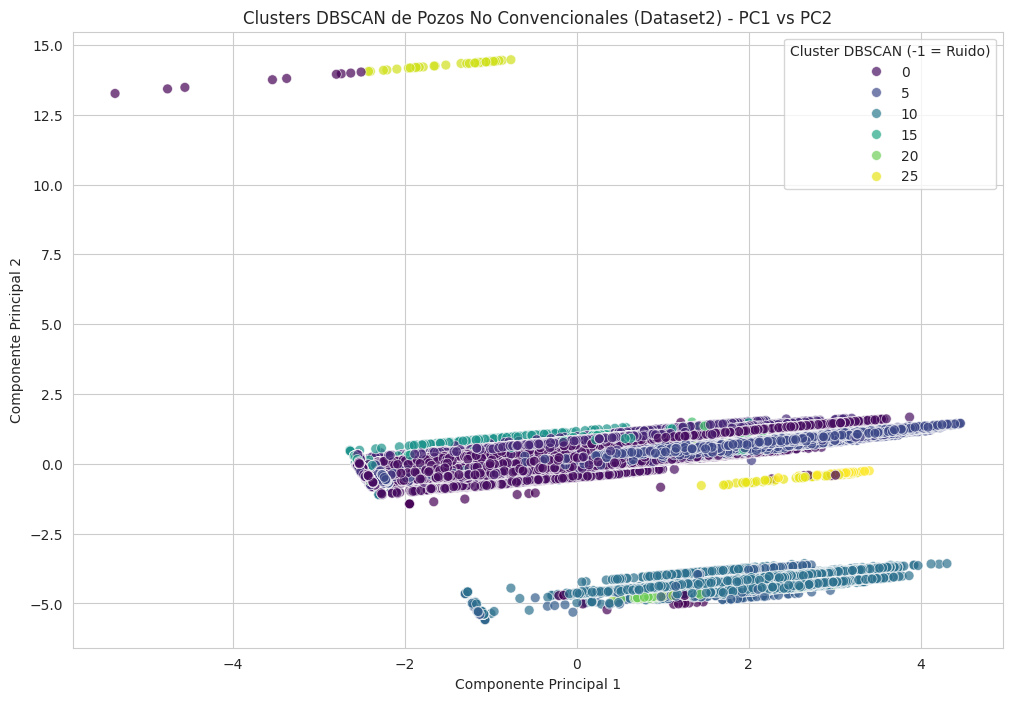

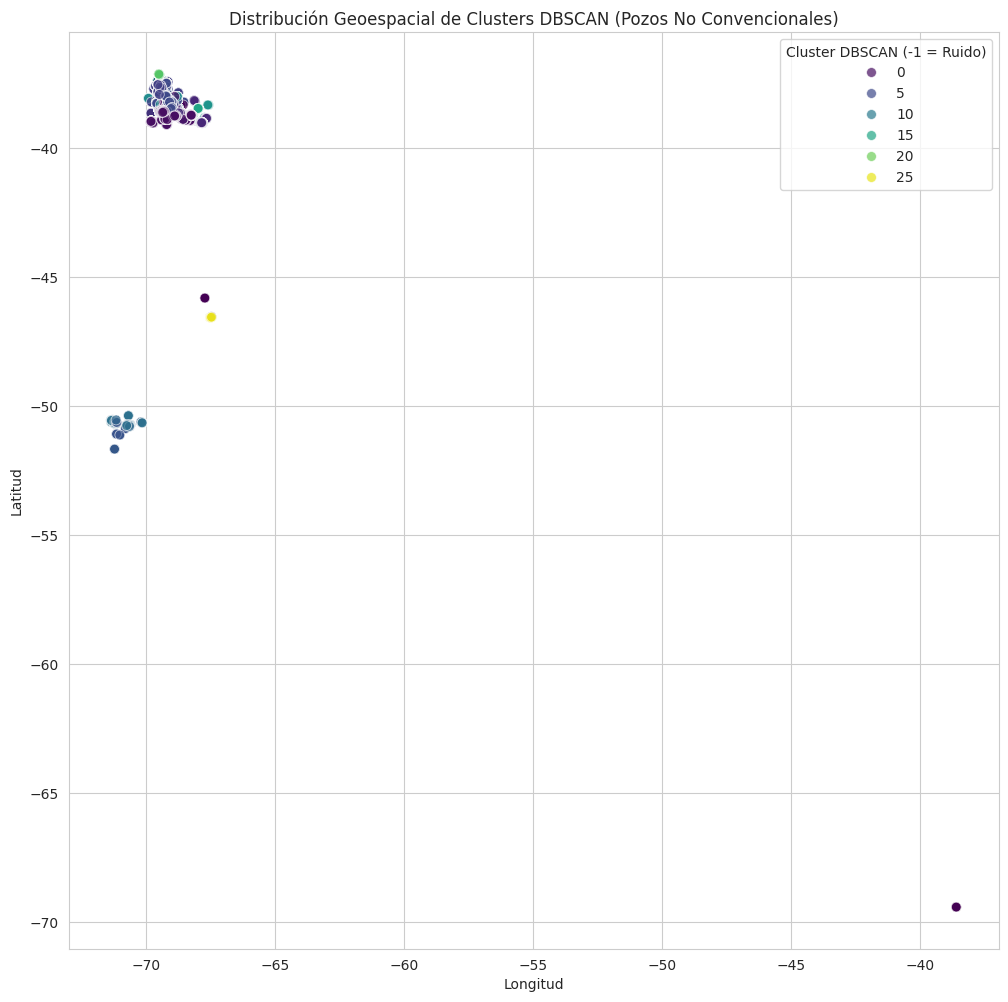


--- Caracter√≠sticas promedio por Cluster (DBSCAN - Dataset2) - Valores Originales: ---
                   prod_gas    prod_pet   prod_agua  coordenaday  coordenadax
dbscan_cluster                                                               
-1.0             662.246093  147.578484  338.455707   -42.318303   -67.554558
 0.0             645.831258   14.349732   58.535285   -38.739655   -68.794906
 1.0             445.224544   17.367198   57.343407   -38.714238   -68.927345
 2.0             475.938644   95.119760   43.668242   -39.010046   -67.834967
 3.0             696.447347   10.952963   38.670623   -38.702582   -68.971402
 4.0             638.375431   58.856361  117.926312   -38.112696   -69.259407
 5.0            3480.345453  186.586880  585.308595   -38.335669   -69.152906
 6.0               0.000000    0.000000    0.000000   -50.899479   -71.011725
 7.0             564.893316   23.629775   32.260004   -50.728267   -70.828227
 8.0               0.000000    0.000000    0.000000  

In [ ]:
# Visualizaci√≥n de Clusters (DBSCAN) en PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='dbscan_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN de Pozos No Convencionales (Dataset2) - PC1 vs PC2')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.grid(True)
plt.show()

# Visualizaci√≥n Geoespacial de Clusters (DBSCAN)
plt.figure(figsize=(12, 12))
sns.scatterplot(x='coordenadax', y='coordenaday', hue='dbscan_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Distribuci√≥n Geoespacial de Clusters DBSCAN (Pozos No Convencionales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# An√°lisis de Caracter√≠sticas promedio por Cluster (DBSCAN)
print("\n--- Caracter√≠sticas promedio por Cluster (DBSCAN - Dataset2) - Valores Originales: ---")

# Columnas num√©ricas originales relevantes para el an√°lisis de clusters
numerical_cols_for_analysis = ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

# Revisar que las columnas existen en df2_with_clusters
existing_numerical_cols = [col for col in numerical_cols_for_analysis if col in df2_with_clusters.columns]

if not existing_numerical_cols:
    print("Advertencia: Ninguna de las columnas num√©ricas especificadas se encontr√≥ en el DataFrame para el an√°lisis de promedios.")
else:
    if 'dbscan_cluster' in df2_with_clusters.columns:
        cluster_summary_dbscan = df2_with_clusters.groupby('dbscan_cluster')[
            existing_numerical_cols
        ].mean()
        print(cluster_summary_dbscan)
    else:
        print("Advertencia: La columna 'dbscan_cluster' no se encontr√≥ en el DataFrame.")


# An√°lisis de proporciones de variables categ√≥ricas por cluster (DBSCAN)
print("\n--- Proporciones de Variables Categ√≥ricas por Cluster (DBSCAN - Dataset2): ---")
# Revisar la lista 'categorical_features_2' est√° definida
if 'categorical_features_2' not in locals() and 'categorical_features_2' not in globals():
    print("Advertencia: La lista 'categorical_features_2' no est√° definida. No se puede realizar el an√°lisis de variables categ√≥ricas.")
else:

    existing_categorical_cols = [col for col in categorical_features_2 if col in df2_with_clusters.columns]

    if not existing_categorical_cols:
        print("Advertencia: Ninguna de las columnas categ√≥ricas especificadas se encontr√≥ en el DataFrame para el an√°lisis de proporciones.")
    else:

        if 'dbscan_cluster' in df2_with_clusters.columns:

            for cluster_id in sorted(df2_with_clusters['dbscan_cluster'].unique()):
                cluster_data = df2_with_clusters[df2_with_clusters['dbscan_cluster'] == cluster_id]
                print(f"\n--- Cluster {cluster_id} ---")
                for cat_col in existing_categorical_cols:
                    if not cluster_data[cat_col].empty:

                        print(f"  {cat_col}:\n{cluster_data[cat_col].value_counts(normalize=True).round(2).dropna()}")
                    else:
                        print(f"  {cat_col}: No hay datos para este cl√∫ster.")
        else:
            print("Advertencia: La columna 'dbscan_cluster' no se encontr√≥ en el DataFrame.")

### An√°lisis de Clusters DBSCAN (Dataset2: Producci√≥n de Pozos No Convencionales)

**DBSCAN** segment√≥ los pozos en 27 clusters m√°s un grupo de outliers, ofreciendo una clasificaci√≥n m√°s fina que K-Means.

**Clusters por Cuenca y Fase:**

* En la Cuenca Neuquina se destacan clusters con alta producci√≥n, especialmente en recursos SHALE y TIGHT en etapas de desarrollo y exploraci√≥n. Tambi√©n hay clusters con producci√≥n baja o nula, identificando pozos en diferentes estados operativos.

* Las Cuencas Austral y Golfo San Jorge muestran clusters con producci√≥n variable, desde alta hasta nula, reflejando su diversidad productiva.

**Outliers (Ruido):**

Pozos at√≠picos con producci√≥n variable, que pueden indicar anomal√≠as o errores en datos.

**Aportes clave de DBSCAN:**

* Identificaci√≥n de micro-regiones geogr√°ficas y operativas.
* Detecci√≥n de pozos con alto potencial productivo y otros con bajo rendimiento.
* Facilita el an√°lisis detallado para decisiones estrat√©gicas m√°s informadas.

**En definitiva, DBSCAN brinda una segmentaci√≥n m√°s granular y √∫til para entender la producci√≥n de pozos no convencionales que m√©todos m√°s generales como K-Means.**



**DBSCAN- An√°lisis de Ruido**

In [ ]:
# Interpretaci√≥n de Outliers (DBSCAN)
outliers_dbscan2 = df2_with_clusters[df2_with_clusters['dbscan_cluster'] == -1]

print("\n--- An√°lisis de Ruido (DBSCAN) ---")
if not outliers_dbscan2.empty:
    print(f"Se identificaron {len(outliers_dbscan2)} pozos outliers por DBSCAN.")
    print("Caracter√≠sticas de los pozos outliers (muestra aleatoria):")

    # Lista de columnas que quieres mostrar para los outliers
    cols_to_show_outliers = [col for col in ['prod_gas', 'prod_pet', 'prod_agua', 'cuenca', 'coordenaday', 'coordenadax'] if col in outliers_dbscan2.columns]


    if cols_to_show_outliers:
        print(outliers_dbscan2[cols_to_show_outliers].sample(min(5, len(outliers_dbscan2)), random_state=42))
    else:
        print("No se encontraron las columnas de producci√≥n/geogr√°ficas especificadas para mostrar caracter√≠sticas de outliers.")

else:
    print("No se identificaron outliers por DBSCAN (cl√∫ster -1).")


--- An√°lisis de Ruido (DBSCAN) ---
Se identificaron 183 pozos outliers por DBSCAN.
Caracter√≠sticas de los pozos outliers (muestra aleatoria):
        prod_gas  prod_pet  prod_agua    cuenca  coordenaday  coordenadax
265138     0.000   0.00000   452.4560  NEUQUINA   -38.526319   -69.496614
100294   303.460  95.25000    52.7300  NEUQUINA   -38.556890   -69.362696
313290   826.970  30.06200     0.0000   AUSTRAL   -50.601610   -71.173080
288925    57.942  60.24817   345.7597  NEUQUINA   -38.148220   -68.807950
311046     0.000  77.96700   151.2420   AUSTRAL   -51.663850   -71.216110


### An√°lisis de Outliers para DBSCAN

DBSCAN identific√≥ 183 pozos como outliers (ruido), ya que no siguen los patrones densos de producci√≥n del resto. Estos pozos presentan comportamientos variados: algunos tienen producci√≥n nula de hidrocarburos pero alta de agua (posiblemente pozos inactivos o de descarte), mientras que otros muestran combinaciones inusuales de gas, petr√≥leo y agua.

Los outliers est√°n distribuidos principalmente en las cuencas **Neuquina y Austral**, sin concentraci√≥n geogr√°fica espec√≠fica. Sus ubicaciones var√≠an considerablemente en latitud, confirmando que se trata de casos at√≠picos dispersos.

En conclusi√≥n, este grupo representa **pozos con caracter√≠sticas heterog√©neas**, que pueden deberse a errores en los datos o a situaciones reales especiales, por lo que requieren an√°lisis detallado individual.



üìå GMM
- An√°lisis de Clusters GMM (Dataset2)


--- Visualizando y Analizando Clusters GMM ---


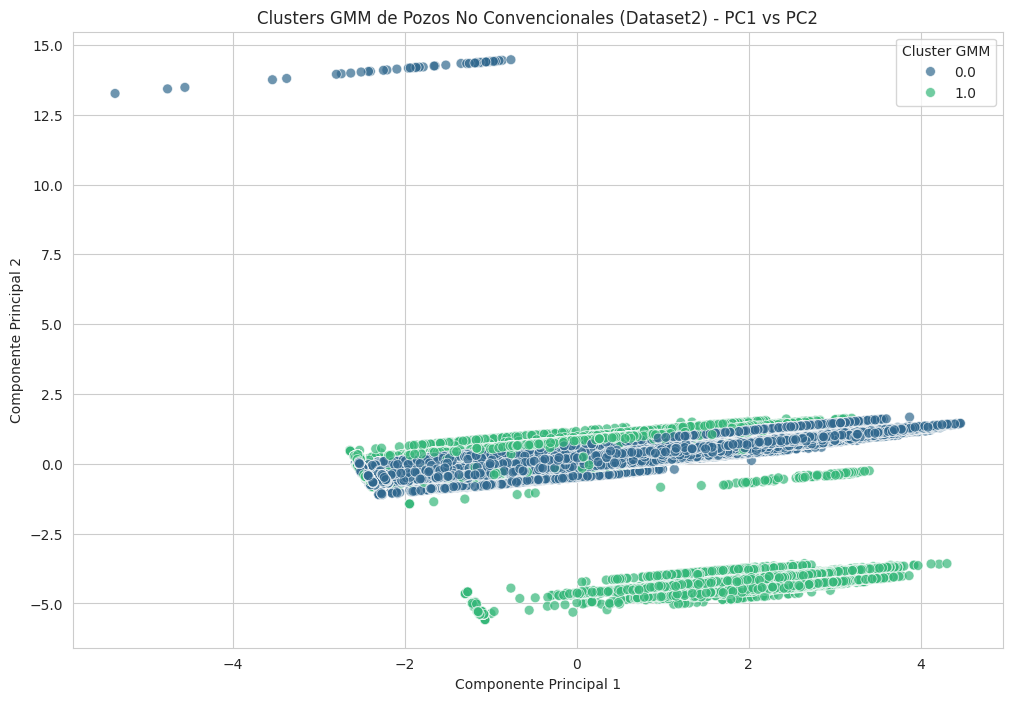

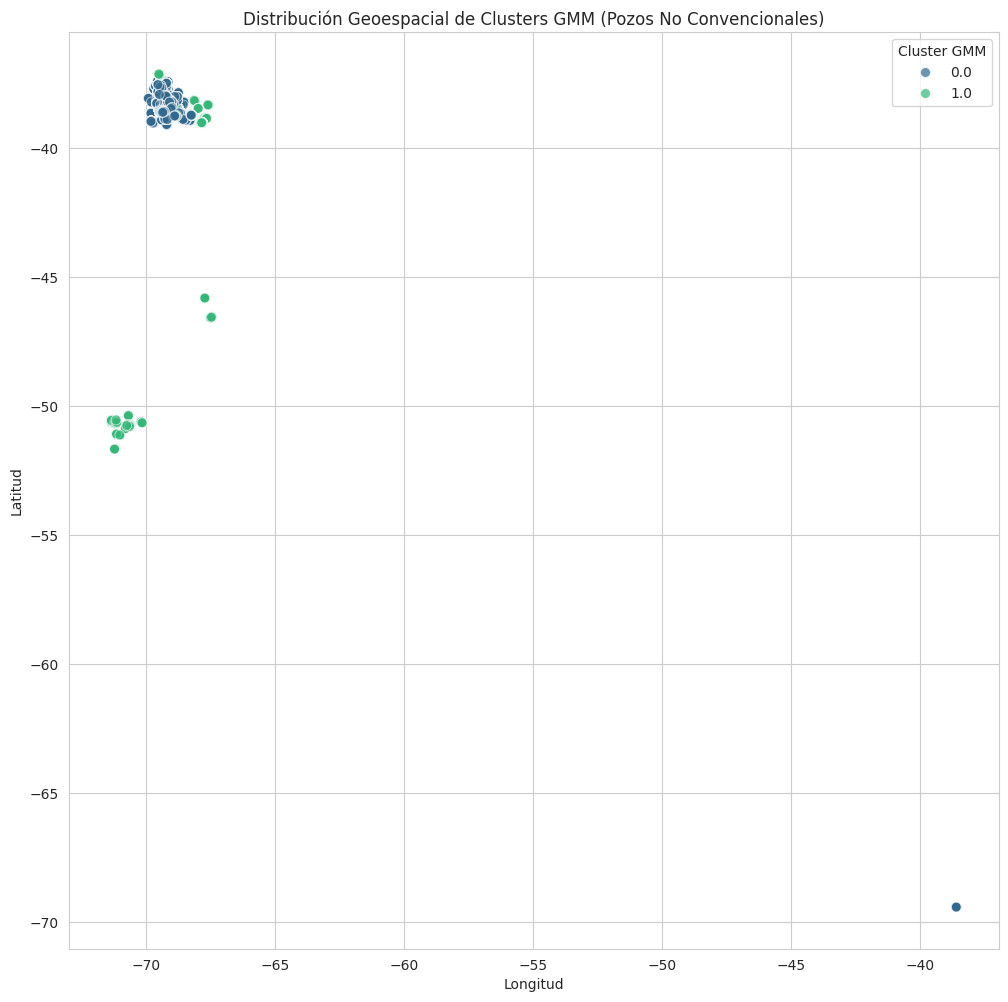


--- Caracter√≠sticas promedio por Cluster (GMM - Dataset2) - Valores Originales: ---
                prod_gas   prod_pet   prod_agua  coordenaday  coordenadax
gmm_cluster                                                              
0.0          1206.607350  49.603219  165.541966   -38.648408   -68.870747
1.0           563.818311  67.361743   57.280996   -42.350972   -68.905121

--- Proporciones de Variables Categ√≥ricas por Cluster (GMM - Dataset2): ---

--- Cluster 0.0 ---
  cuenca:
cuenca
NEUQUINA    1.0
Name: proportion, dtype: float64
  provincia:
provincia
Neuqu√©n    1.0
Name: proportion, dtype: float64
  sub_tipo_recurso:
sub_tipo_recurso
TIGHT    0.77
SHALE    0.23
Name: proportion, dtype: float64
  subclasificacion:
subclasificacion
DESARROLLO               0.94
EXPLORACION              0.04
EXTENSION                0.01
EXPLORATORIO PROFUNDO    0.01
Name: proportion, dtype: float64

--- Cluster 1.0 ---
  cuenca:
cuenca
NEUQUINA           0.71
AUSTRAL            0.29
GOLFO S

In [ ]:
# An√°lisis de Clusters GMM (Dataset2)

print("\n--- Visualizando y Analizando Clusters GMM ---")

# Visualizaci√≥n de Clusters (GMM) en PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='gmm_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters GMM de Pozos No Convencionales (Dataset2) - PC1 vs PC2')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster GMM')
plt.grid(True)
plt.show()

# Visualizaci√≥n Geoespacial de Clusters (GMM)
plt.figure(figsize=(12, 12))
sns.scatterplot(x='coordenadax', y='coordenaday', hue='gmm_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Distribuci√≥n Geoespacial de Clusters GMM (Pozos No Convencionales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster GMM')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

#  An√°lisis de Caracter√≠sticas promedio por Cluster (GMM)
print("\n--- Caracter√≠sticas promedio por Cluster (GMM - Dataset2) - Valores Originales: ---")

# Columnas num√©ricas originales relevantes para el an√°lisis de clusters
numerical_cols_for_analysis = ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

# Revisar que las columnas existen en df2_with_clusters
existing_numerical_cols = [col for col in numerical_cols_for_analysis if col in df2_with_clusters.columns]

if not existing_numerical_cols:
    print("Advertencia: Ninguna de las columnas num√©ricas especificadas se encontr√≥ en el DataFrame para el an√°lisis de promedios.")
else:
    cluster_summary_gmm = df2_with_clusters.groupby('gmm_cluster')[
        existing_numerical_cols
    ].mean()
    print(cluster_summary_gmm)

#  An√°lisis de proporciones de variables categ√≥ricas por cluster (GMM)
print("\n--- Proporciones de Variables Categ√≥ricas por Cluster (GMM - Dataset2): ---")
if 'categorical_features_2' not in locals() and 'categorical_features_2' not in globals():
    print("Advertencia: La lista 'categorical_features_2' no est√° definida. No se puede realizar el an√°lisis de variables categ√≥ricas.")
else:
    # Revisar que las columnas categ√≥ricas existen en df2_with_clusters
    existing_categorical_cols = [col for col in categorical_features_2 if col in df2_with_clusters.columns]

    if not existing_categorical_cols:
        print("Advertencia: Ninguna de las columnas categ√≥ricas especificadas se encontr√≥ en el DataFrame para el an√°lisis de proporciones.")
    else:
        for cluster_id in sorted(df2_with_clusters['gmm_cluster'].unique()):
            cluster_data = df2_with_clusters[df2_with_clusters['gmm_cluster'] == cluster_id]
            print(f"\n--- Cluster {cluster_id} ---")
            for cat_col in existing_categorical_cols:
                if not cluster_data[cat_col].empty:
                    print(f"  {cat_col}:\n{cluster_data[cat_col].value_counts(normalize=True).round(2)}")
                else:
                    print(f"  {cat_col}: No hay datos para este cl√∫ster.")

### **An√°lisis Detallado de Clusters GMM (Dataset2: Producci√≥n de Pozos No Convencionales)**

El modelo Gaussian Mixture Models (GMM) dividi√≥ el conjunto de pozos no convencionales en dos grandes grupos, permitiendo una segmentaci√≥n m√°s flexible que otros m√©todos al considerar formas de cl√∫ster m√°s complejas.

**Cluster 0.0 ‚Äì Alta Productividad en Neuqu√©n**

Este grupo re√∫ne pozos con muy alta producci√≥n de gas (promedio ~1200 m¬≥), y niveles moderados de petr√≥leo y agua.
Todos los pozos est√°n ubicados en la Cuenca Neuquina, espec√≠ficamente en la provincia de Neuqu√©n, lo que indica una fuerte concentraci√≥n geogr√°fica.
* **Tipo de recurso:** Mayor√≠a TIGHT (77%), seguido por SHALE (23%).
* **Fase del proyecto:** Predomina la fase de desarrollo (94%).

Representa el **coraz√≥n de la actividad no convencional** en Vaca Muerta, con pozos de alto rendimiento y desarrollo intensivo.

**Cluster 1.0 ‚Äì Producci√≥n Mixta en Regiones Diversas**

Incluye pozos con una producci√≥n m√°s equilibrada, donde el gas es moderado (560 m¬≥ aprox.), pero el petr√≥leo tiene mayor presencia (67 m¬≥ aprox.).

Estos pozos est√°n distribuidos en varias provincias, principalmente en R√≠o Negro y Santa Cruz, con menor presencia en Neuqu√©n y Mendoza.

* **Tipo de recurso:** Casi exclusivamente TIGHT (98%).
* **Fase:** Mayor diversidad, con presencia importante de pozos en fase avanzada (24%) y desarrollo (71%).

Representa **zonas m√°s heterog√©neas**, con una combinaci√≥n de recursos y estrategias productivas, orientadas tanto a gas como a petr√≥leo.

**Casos No Asignados (NaN)**

Algunos pozos no fueron asignados a ning√∫n cl√∫ster, lo que puede deberse a que GMM no los incluye en sus componentes principales, aunque no los marca expl√≠citamente como ‚Äúruido‚Äù como lo hace DBSCAN.

---

**Conclusi√≥n**

El modelo GMM proporciona una **visi√≥n general clara y estrat√©gica** del panorama de producci√≥n no convencional en Argentina:

* Por un lado, Neuqu√©n se destaca como el epicentro gas√≠fero, con pozos altamente productivos.

* Por otro, aparece un segundo grupo m√°s diverso en ubicaci√≥n y caracter√≠sticas, reflejando enfoques t√©cnicos variados y recursos mixtos.

GMM resulta √∫til para un an√°lisis de alto nivel, y puede complementarse con m√©todos m√°s detallados como DBSCAN, ideal para profundizar en particularidades o identificar anomal√≠as.

#### üìä Comparaci√≥n  

- Comparaci√≥n entre K-Means, DBSCAN y GMM

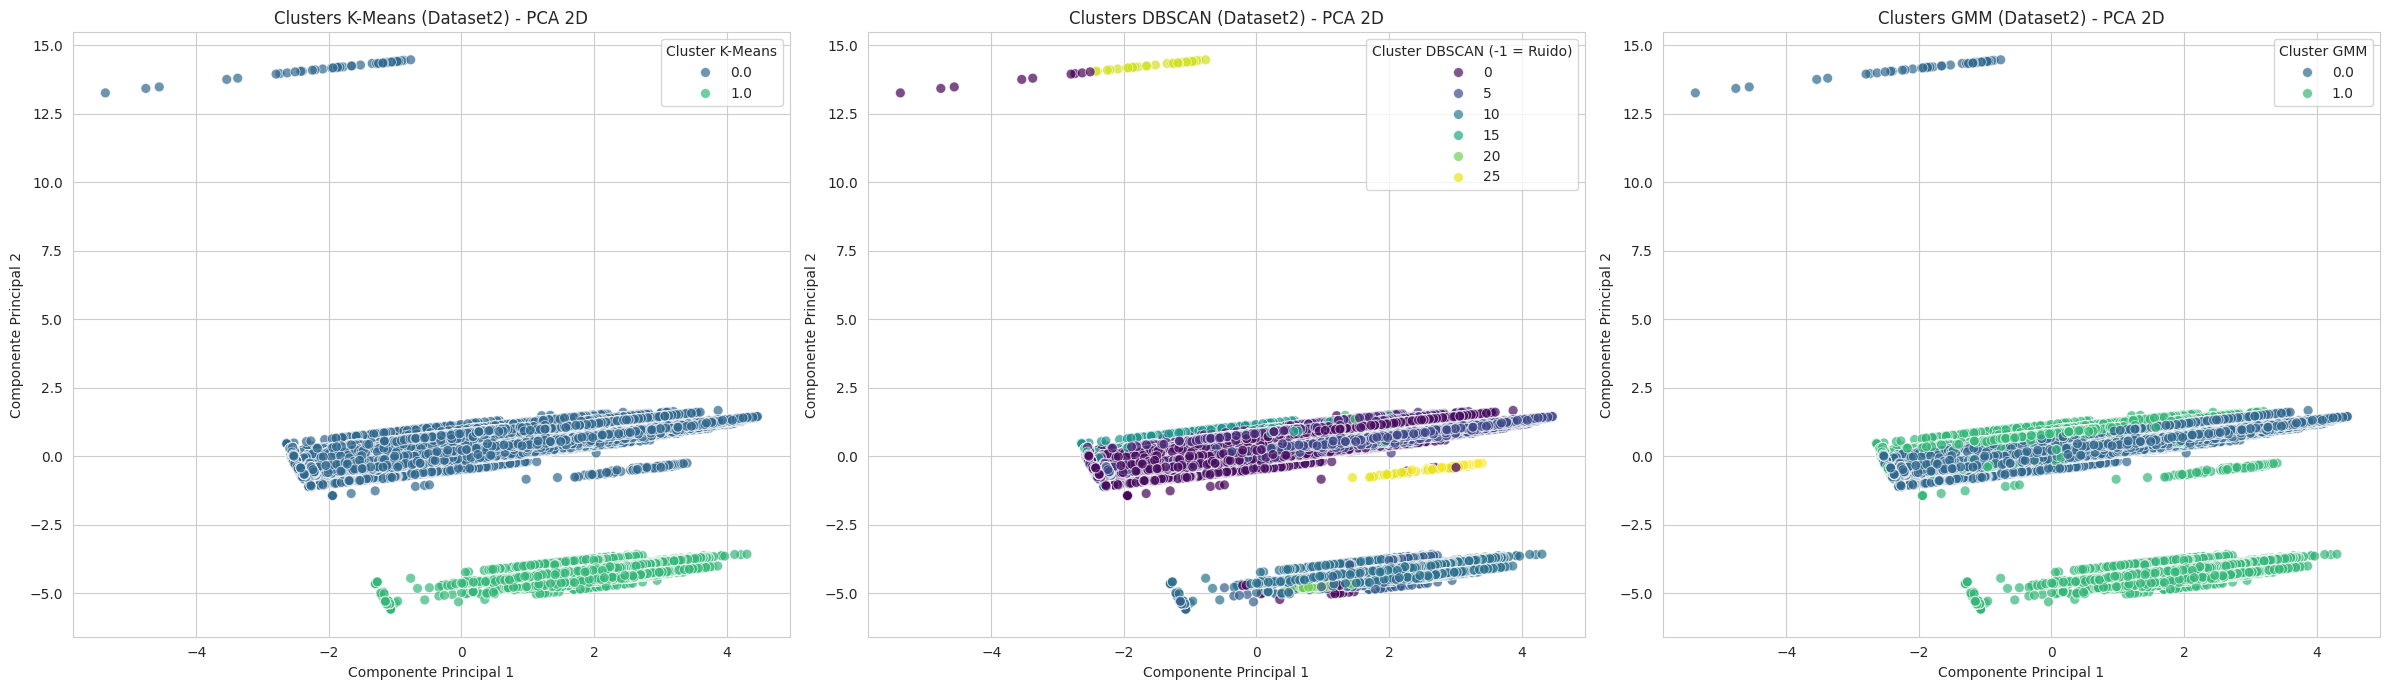

In [ ]:
# Visualizaci√≥n Comparativa de Clusters (K-Means, DBSCAN, GMM) en PCA 2D

plt.figure(figsize=(24, 7))

# Gr√°fico de Clusters (K-Means)
plt.subplot(1, 3, 1)
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='kmeans_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters K-Means (Dataset2) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.grid(True)

# Gr√°fico de Clusters (DBSCAN)
plt.subplot(1, 3, 2)
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='dbscan_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN (Dataset2) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.grid(True)

# Gr√°fico de Clusters (GMM)
plt.subplot(1, 3, 3)
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='gmm_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters GMM (Dataset2) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster GMM')
plt.grid(True)

plt.tight_layout()
plt.show()

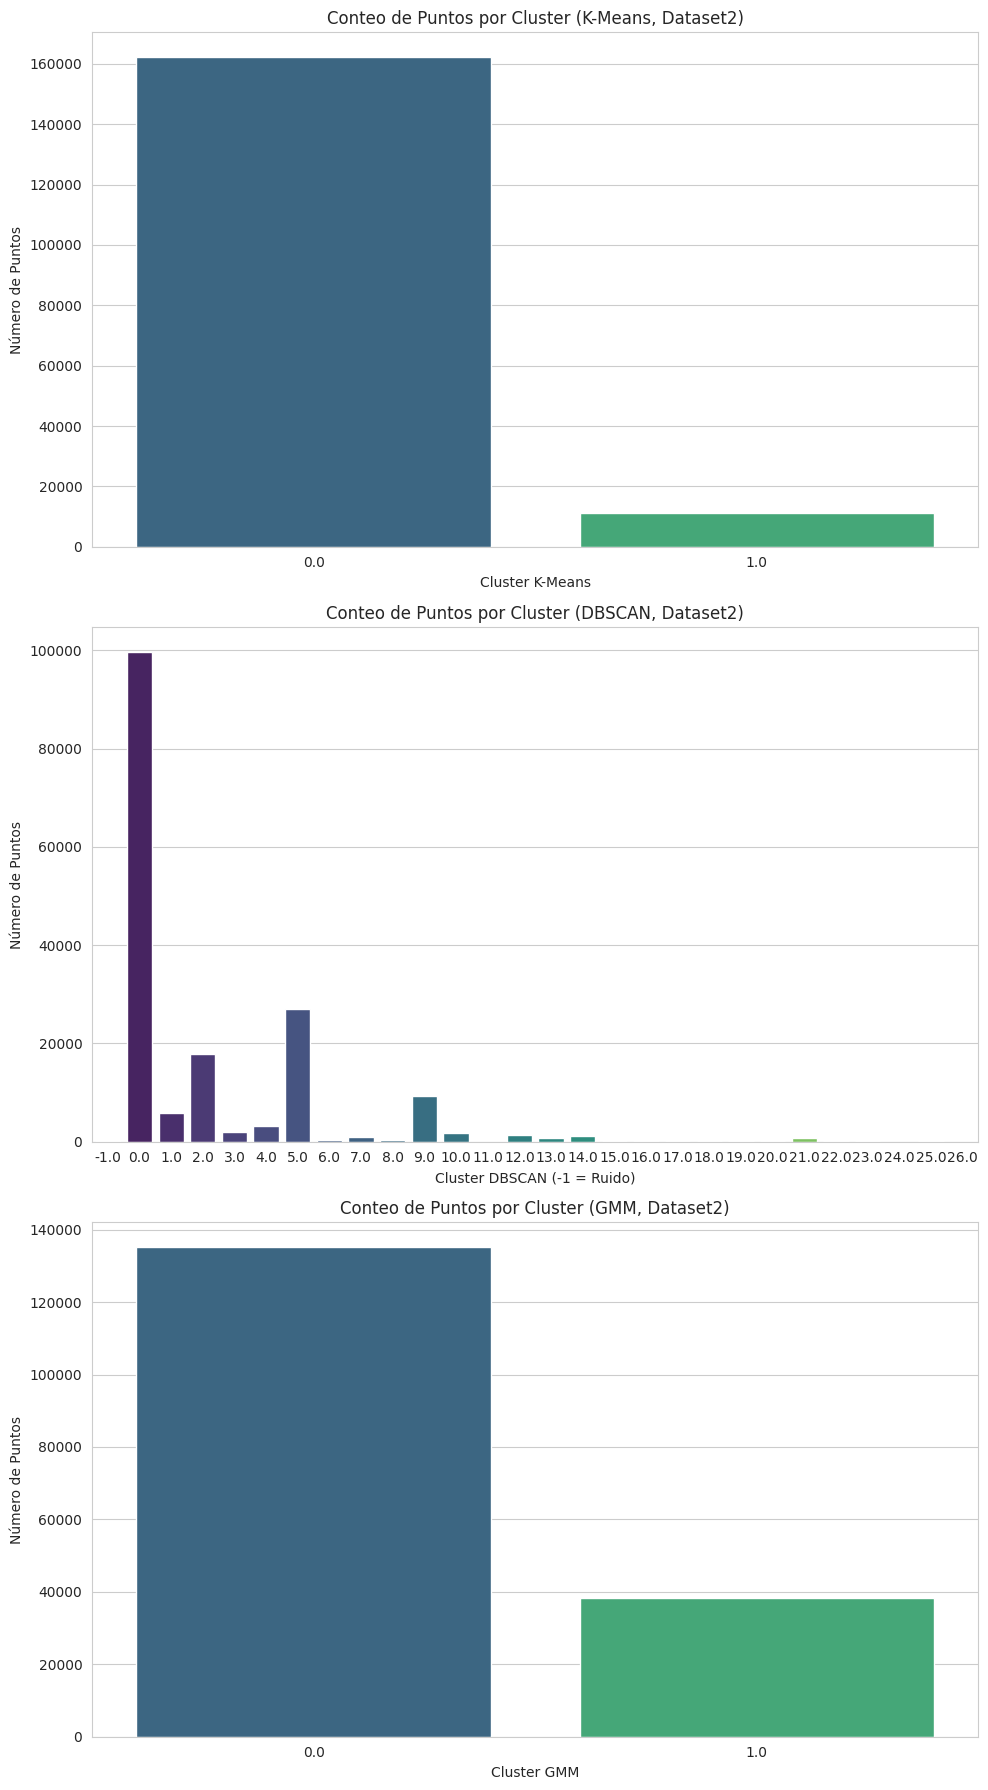

In [ ]:
# Conteo de Puntos por Clusters seg√∫n Modelo

plt.figure(figsize=(10, 18))

# Conteo para K-Means
plt.subplot(3, 1, 1)
kmeans_counts = df2_with_clusters['kmeans_cluster'].value_counts().sort_index()
sns.barplot(x=kmeans_counts.index, y=kmeans_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (K-Means, Dataset2)')
plt.xlabel('Cluster K-Means')
plt.ylabel('N√∫mero de Puntos')
plt.xticks(rotation=0)

# Conteo para DBSCAN
plt.subplot(3, 1, 2)
dbscan_counts = df2_with_clusters['dbscan_cluster'].value_counts().sort_index()
sns.barplot(x=dbscan_counts.index, y=dbscan_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (DBSCAN, Dataset2)')
plt.xlabel('Cluster DBSCAN (-1 = Ruido)')
plt.ylabel('N√∫mero de Puntos')
plt.xticks(rotation=0)

# Conteo para GMM
plt.subplot(3, 1, 3)
gmm_counts = df2_with_clusters['gmm_cluster'].value_counts().sort_index()
sns.barplot(x=gmm_counts.index, y=gmm_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (GMM, Dataset2)')
plt.xlabel('Cluster GMM')
plt.ylabel('N√∫mero de Puntos')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### **Comparaci√≥n entre GMM, K-Means y DBSCAN**

Los tres algoritmos aplicados al Dataset2 ofrecen distintas formas de agrupar los pozos no convencionales:

**K-Means**

Agrupa en funci√≥n de distancias, formando cl√∫steres esf√©ricos. Gener√≥ dos grupos principales seg√∫n niveles de producci√≥n: uno de alta productividad concentrado en Neuqu√©n, y otro con producci√≥n baja o intermedia en otras provincias. Es r√°pido y f√°cil de interpretar, pero limitado ante formas complejas o ruido.

**DBSCAN**

Basado en densidad, detecta autom√°ticamente cl√∫steres de cualquier forma y outliers. Identific√≥ 27 cl√∫steres y un grupo de ruido, permitiendo una segmentaci√≥n muy detallada por cuenca, tipo de recurso y fase. Es ideal para exploraci√≥n fina y detecci√≥n de anomal√≠as.

**GMM**
Asume que los datos siguen una mezcla de gaussianas, permitiendo cl√∫steres el√≠pticos y asignaciones probabil√≠sticas. Form√≥ dos grupos: uno altamente productivo en Neuqu√©n (TIGHT/SHALE en desarrollo) y otro m√°s diverso, con mayor producci√≥n de petr√≥leo, en R√≠o Negro y Santa Cruz.

### üßæ Conclusiones Generales sobre los Patrones en Dataset2  

**1. Dominio de la Cuenca Neuquina**

Los tres modelos coinciden en identificar a **Neuqu√©n** como n√∫cleo de la **mayor productividad gas√≠fera**.
Este patr√≥n est√° claramente marcado por pozos en fase de desarrollo, principalmente de tipo TIGHT y SHALE. DBSCAN adem√°s distingue entre estas tecnolog√≠as y revela subzonas de inter√©s en Mendoza y R√≠o Negro.

**2. Producci√≥n Mixta y Diversidad Geogr√°fica**

Otro patr√≥n importante se da en **R√≠o Negro, Santa Cruz y Mendoza**, donde los pozos presentan menor producci√≥n de gas pero **mayor presencia de petr√≥leo**, en fases m√°s avanzadas. K-Means y GMM captan este grupo m√°s heterog√©neo, mientras DBSCAN lo descompone en m√∫ltiples cl√∫steres por cuenca.

**3. Pozos At√≠picos o con Comportamiento Inusual**

DBSCAN detect√≥ 183 pozos como outliers, con combinaciones at√≠picas como nula producci√≥n de hidrocarburos y alta producci√≥n de agua. Estos casos podr√≠an reflejar pozos inactivos, de servicio, o errores de registro, y requieren an√°lisis puntual.

**4. Impacto de la Frecuencia y Densidad de Pozos**

Cada modelo responde distinto seg√∫n la forma y densidad de los datos:

| Modelo   | Enfoque Principal | Fortalezas | Limitaciones |
|----------|-------------------|------------|--------------|
| **K-Means** | Centrado en centroides (formas esf√©ricas) | Visi√≥n r√°pida y global de los patrones predominantes | No maneja bien ruido ni formas complejas |
| **GMM**     | Asume distribuci√≥n gaussiana (formas el√≠pticas) | Flexibilidad en las formas, asignaciones probabil√≠sticas | Menos granularidad |
| **DBSCAN**  | Densidad local de puntos | Detecta cl√∫steres peque√±os y outliers, granularidad alta | Sensible a los par√°metros, m√°s complejo de interpretar |

---

#### **Conclusi√≥n Final**

Los pozos no convencionales de Argentina pueden clasificarse en grupos bien definidos seg√∫n su productividad y ubicaci√≥n. Esto permite:

* Entender mejor los tipos de activos disponibles
* Analizar sus caracter√≠sticas t√©cnicas
* Tomar decisiones estrat√©gicas o de inversi√≥n m√°s informadas

La elecci√≥n del algoritmo depende del objetivo del an√°lisis:
* K-Means y GMM son √∫tiles para una visi√≥n general o estrat√©gica
* DBSCAN es ideal para an√°lisis detallados y detecci√≥n de anomal√≠as


---

### üßæ **Conclusiones Generales de los insights de los Modelos No Supervisados**

El an√°lisis con modelos no supervisados revela una transici√≥n estructural en la industria:

**Dataset 1:** Muestra el cambio desde la producci√≥n convencional a la no convencional (shale y tight gas), con Neuqu√©n como protagonista. K-Means identifica la transici√≥n global, mientras DBSCAN revela fases intermedias y micro-patrones temporales.

**Dataset 2:** Confirma que la Cuenca Neuquina alberga los pozos m√°s productivos, principalmente en desarrollo y con alto contenido de gas. Paralelamente, hay zonas con producci√≥n mixta y diversa en R√≠o Negro, Santa Cruz y Mendoza. La detecci√≥n de outliers por parte de DBSCAN subraya la importancia de investigar pozos con comportamiento an√≥malo, tanto para corregir errores como para detectar nuevas oportunidades.

